In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import itertools

import torch
from torch import nn

import youtokentome as yttm

from utils.base import get_params_number, init_random_seed, train_loop_GAN, save_texts_to_file
from utils.poetry import *
from utils.transformer_tools import *

init_random_seed(1702)

In [2]:
horus = load_chunks("./datasets/Eragon/Eragon_red.txt", chunk_size=300)

ALL_LEN = len(horus)
print(ALL_LEN)
len_for_steps = int(ALL_LEN / 3)
horus_for_GAN = horus[len_for_steps * 2:]
horus = horus[:len_for_steps * 2]
print(len(horus))
print(len(horus_for_GAN))

23766
15844
7922


In [3]:
for_mauve_test = horus_for_GAN[len(horus_for_GAN)-100:]
horus_for_GAN = horus_for_GAN[:len(horus_for_GAN)-100]

print(len(horus_for_GAN))
print(len(for_mauve_test))

7822
100


In [4]:
BPE_MODEL_FILENAME = './models/tokens/eragon_bpe_1000.yttm'

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e a t o n r h i s d l u g w m c f y p . , b v k I ’ “ ” E T A S H W R ? x B z N O G j — M D Y - q F ! V C L ; U K û J P : ö í Z ë é Q ‘ á ) ( Û ä 0 / ó î Í 2 â ï ú 5 3 ü 1 7 – ô Ä 9 $ X 8 ° © ] [ 6 4 ê Ú É ▁t he ▁a in ▁s ▁the ed ▁w ou on ▁h re nd er ▁b ▁f ▁o is ra ▁c at ▁to it ing ▁m en ar ▁d ▁and or ▁he ▁of es ll ▁l ▁th an ro as ▁p ▁n ▁“ ▁e ▁in ▁y ad ▁you id ▁I ▁g ld ▁his gh ▁be ▁E rag im ow le ragon ve st ▁T ot ith ▁st ▁Eragon ▁u ▁as ac ▁re ▁on al se ir ▁with ▁S ri ▁it ur ▁that ▁we ▁ha ▁was ver ly ▁A hi ’s .” ▁for ent ght ▁H rom ould ut om ▁The et ce ap ▁her ay ▁an ion ▁him ill ▁sa out ard ▁k ▁R ▁wh her ▁had ▁not ain oo il ▁sh ▁at s, if ic ch s. ran rou ted ▁He ter ore all ▁from ▁have ke ▁me ▁so ▁B pp ▁se ▁W hed ag am ▁they ked ru ▁but ight ▁is ▁said hira aphira ▁Saphira ▁le e, el ▁them ▁sp ec ▁she ▁con e. ▁O ▁their ’t ▁do ▁would ?” th ▁ex ▁were ind hen our ry ong ▁G ▁your ed, ▁su ▁“I ▁kn ▁ne ▁li ▁N ▁— lf ▁then ▁un ed. ack ▁v oran ▁int ▁M and em ble ▁cl ves 

In [5]:
token_ids = tokenizer.encode(horus_for_GAN, bos=True, eos=True)

unknown_subwords_in_test = sum(1 for text in token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов', unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов 0


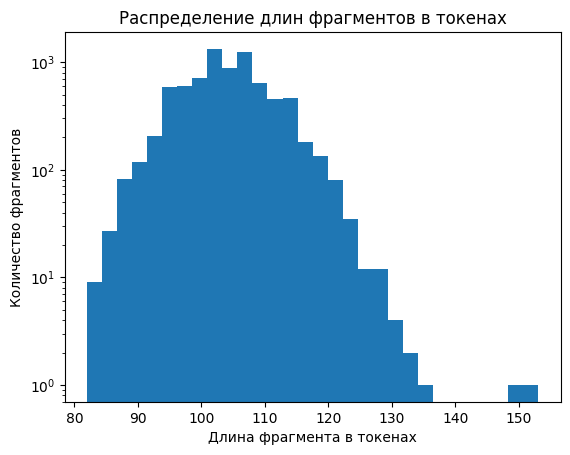

In [6]:
plt.hist([len(sent) for sent in token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.xlabel("Длина фрагмента в токенах")
plt.ylabel("Количество фрагментов")
plt.yscale('log')

In [8]:
start_length = 20
end_length = 60

all_dataset = Dataset_for_GAN(token_ids, start_len=start_length, end_len=end_length)

In [9]:
check = all_dataset[2036]

print(check[0])
print(check[1])
print(tokenizer.decode(check[0].tolist()))
print(tokenizer.decode(check[1].tolist()))

[595 176 110 368  19 117 806 121 296 136 298 147 130 588 210 591 394 266
 168 139]
[159 820 328 585  13  19 133 197 699 165 397 270 953   5 128 267 278 768
 109 138 180 114 267 139 274 311 134 136 274 118 469 136 354 113 143 685
 188 135 185 168 110 382 129 692  24 606 298 661 254 950 157 496   9 131
 229 808 448 392   4 155]
['well as a common fighter — and then pitting her against twelve of']
['his finest swordsmen.” “How did she defeat them?” “She healed them of their fear and their hate and all the things that drive a man to kill. And then while they stood grinning at each other like id']


In [10]:
D_model = LSTM_Discriminator(100, 256, tokenizer.vocab_size())
print('Количество параметров дискриминатора', get_params_number(D_model))

G_model = Language_Model(
    vocab_size = tokenizer.vocab_size(),
    embedding_size = 256,
    backbone = Transformer_Encoder(
        nn.TransformerEncoderLayer(
            d_model = 256,
            nhead = 16,
            dim_feedforward = 512,
            dropout = 0.1
        ),
        num_layers=5
    ),
    emb_dropout = 0.1
)
print('Количество параметров генератора', get_params_number(G_model))

Количество параметров дискриминатора 399301
Количество параметров генератора 3148520


In [12]:
optimizer_SD_G = torch.load('./models/Lord/Eragon/Lord_opt.pth')
G_model.load_state_dict(torch.load('./models/Lord/Eragon/Lord.pth'))

<All keys matched successfully>

In [13]:
batch_size = 64

model_D, model_G, optimizer_D, optimizer_G, loss_history_D, loss_history_G = train_loop_GAN(
    D_model,
    G_model,
    all_dataset,
    lm_b_cross_entropy,
    lr_D=1e-2,
    lr_G=1e-2,
    epoch_n=1000,
    batch_size=batch_size,
    device='cuda',
    # early_optimizer_SD_D=optimizer_SD_D,
    early_optimizer_SD_G=optimizer_SD_G,
    tokenizer=tokenizer,
    need_to_gen=True,
    end_chunk=end_length,
    phrase="Today we are going"
)

Эпоха 0


123it [00:59,  2.07it/s]


Эпоха прошла за 59.33 секунд
Средняя функция потерь для дискриминатора = 0.7035545055580333
Средняя функция потерь для генератора = 2.3691782372269206
Today we are going tomorrow, but we can’t go to the Varden.” Eragon gestured at Murtagh. “For the first time we’ll have to leave.” Murtagh shook his head.
Следующая эпоха
Эпоха 1


123it [00:58,  2.10it/s]


Эпоха прошла за 58.62 секунд
Средняя функция потерь для дискриминатора = 0.06978082507697304
Средняя функция потерь для генератора = 5.258122847332218
Today we are going in the middle of Alagaësia.” She paused. “Perhaps,” said Angela. “Of course not, I
Следующая эпоха
Эпоха 2


123it [00:58,  2.09it/s]


Эпоха прошла за 58.79 секунд
Средняя функция потерь для дискриминатора = 0.04113429546454633
Средняя функция потерь для генератора = 6.299775906694614
Today we are going to Tronjheim. We can’t go to Tronjheim. They’ll be safely here for the rest of the Beor Mountains, but they’ll be
Следующая эпоха
Эпоха 3


123it [00:58,  2.09it/s]


Эпоха прошла за 58.77 секунд
Средняя функция потерь для дискриминатора = 0.04303621391129748
Средняя функция потерь для генератора = 6.834927074308318
Today we are going to Tronjheim.” “And what will you do?” Orik shrugged. “Once we can get out of here.” “Fine,” said Eragon, “but
Следующая эпоха
Эпоха 4


123it [00:58,  2.09it/s]


Эпоха прошла за 58.81 секунд
Средняя функция потерь для дискриминатора = 0.04423734378372508
Средняя функция потерь для генератора = 6.476590148801726
Today we are going to Teirm, and I will be able to escape for the rest of your life.” “Onlyour day,” said Brom. “Of cour
Следующая эпоха
Эпоха 5


123it [00:59,  2.06it/s]


Эпоха прошла за 59.66 секунд
Средняя функция потерь для дискриминатора = 0.019910353637201998
Средняя функция потерь для генератора = 7.416053686684709
Today we are going to Tronjheim. That is why we aren’t going here?” asked Eragon. He shook his head. “I’m not going to get out of here,” said
Следующая эпоха
Эпоха 6


123it [01:00,  2.04it/s]


Эпоха прошла за 60.22 секунд
Средняя функция потерь для дискриминатора = 0.01782854890727203
Средняя функция потерь для генератора = 7.714709704484397
Today we are going in the Spine, and we can cross the Empire.” “Yes, Ma’am.” “Good. We’ve never seen before,” said Brom, “but
Следующая эпоха
Эпоха 7


123it [00:58,  2.10it/s]


Эпоха прошла за 58.65 секунд
Средняя функция потерь для дискриминатора = 0.015281949033279245
Средняя функция потерь для генератора = 7.995974125900889
Today we are going together.” “Of course,” said Eragon, “but we can’t go to the ground.” “Yes,” said Brom. He gestured at the corner
Следующая эпоха
Эпоха 8


123it [00:58,  2.09it/s]


Эпоха прошла за 58.83 секунд
Средняя функция потерь для дискриминатора = 0.01833710708320368
Средняя функция потерь для генератора = 8.146408802125512
Today we are going to Cithríhví.” “And what is it?” “Of course not,” said Eragon. “Good. That is why you aren’t going to
Следующая эпоха
Эпоха 9


123it [00:58,  2.10it/s]


Эпоха прошла за 58.67 секунд
Средняя функция потерь для дискриминатора = 0.014072863068488404
Средняя функция потерь для генератора = 9.17434280674632
Today we are going?” asked Eragon. “Once we are in Tronjheim, I will be able to see if we can accompany me. We’ll have to go to the
Следующая эпоха
Эпоха 10


123it [00:58,  2.10it/s]


Эпоха прошла за 58.68 секунд
Средняя функция потерь для дискриминатора = 0.013044596728736277
Средняя функция потерь для генератора = 9.356206482988062
Today we are going to call ourselves.” “Of course,” said Brom. “These are too late. We can’t stay here for the night.” Eragon shook his head.
Следующая эпоха
Эпоха 11


123it [00:58,  2.09it/s]


Эпоха прошла за 58.83 секунд
Средняя функция потерь для дискриминатора = 0.010444128986427227
Средняя функция потерь для генератора = 9.27919126526127
Today we are going to Tronjheim. We can’t go anywhere in the Beor River.” After a minute, Eragon asked, “Where are you going?” The dwarf
Следующая эпоха
Эпоха 12


123it [00:58,  2.09it/s]


Эпоха прошла за 58.76 секунд
Средняя функция потерь для дискриминатора = 0.011475103332545623
Средняя функция потерь для генератора = 10.05411519461531
Today we are going together. We can’t be able to find a certain ways.” “Perhaps I’ve never seen anything else. It’s a matter of
Следующая эпоха
Эпоха 13


123it [00:58,  2.10it/s]


Эпоха прошла за 58.55 секунд
Средняя функция потерь для дискриминатора = 0.01346595215668421
Средняя функция потерь для генератора = 9.08798996995135
Today we are going in the Spine.” “That’s why we’re going to find the Ra’zac?” asked Roran. “Perhaps we can find a few months.” “T
Следующая эпоха
Эпоха 14


123it [00:58,  2.09it/s]


Эпоха прошла за 58.82 секунд
Средняя функция потерь для дискриминатора = 0.013724620824436491
Средняя функция потерь для генератора = 9.35500400046992
Today we are going to hide the rooms in the center of Tronjheim’s city. We have to go with ourselves to the Varden. They’ll be able to
Следующая эпоха
Эпоха 15


123it [00:58,  2.09it/s]


Эпоха прошла за 58.99 секунд
Средняя функция потерь для дискриминатора = 0.012050409597577527
Средняя функция потерь для генератора = 9.823715349523033
Today we are going.” “Come now,” said Brom. “Yes, but I don’t know. That is why you’ve been here?” “No. . I don’t want to be able to
Следующая эпоха
Эпоха 16


123it [00:58,  2.08it/s]


Эпоха прошла за 59.0 секунд
Средняя функция потерь для дискриминатора = 0.012187774911166994
Средняя функция потерь для генератора = 9.5872192460347
Today we are going.” “Perhaps,” said Brom. “Yes.” He gestured toward the corner of his eye. “For a long while ago,” said Brom.
Следующая эпоха
Эпоха 17


123it [00:58,  2.09it/s]


Эпоха прошла за 58.96 секунд
Средняя функция потерь для дискриминатора = 0.01023898292481956
Средняя функция потерь для генератора = 10.099557457900628
Today we are going to Teirm, and I can’t be able to find out the citadeless.” “Perhaps,” said Roran, “but we’ll be a
Следующая эпоха
Эпоха 18


123it [00:58,  2.10it/s]


Эпоха прошла за 58.7 секунд
Средняя функция потерь для дискриминатора = 0.01132961854750832
Средняя функция потерь для генератора = 10.422767150692824
Today we are going.” “Yes, Master,” said Eragon, “but we can’t go together, and we can’t be able to escape the Empire.” He stopped, then
Следующая эпоха
Эпоха 19


123it [00:58,  2.09it/s]


Эпоха прошла за 58.87 секунд
Средняя функция потерь для дискриминатора = 0.013546929879036421
Средняя функция потерь для генератора = 11.494212840630755
Today we are going together. We are awkward, but we have to go.” “Perhaps,” said Eragon, “but we can’t get tomorrow. It’s
Следующая эпоха
Эпоха 20


123it [00:58,  2.11it/s]


Эпоха прошла за 58.41 секунд
Средняя функция потерь для дискриминатора = 0.016805028727082196
Средняя функция потерь для генератора = 10.780455224882296
Today we are going to Tronjheim.” “And what do you want?” asked Eragon. Orik shook his head. “Aye,” said Ajihad. “Your possession is
Следующая эпоха
Эпоха 21


123it [00:58,  2.10it/s]


Эпоха прошла за 58.48 секунд
Средняя функция потерь для дискриминатора = 0.004739073014887224
Средняя функция потерь для генератора = 10.439693699038125
Today we are going along the Beor Mountains.” Eragon shook his head. “Maybe,” said Angela. “Of course. . I have to do this,
Следующая эпоха
Эпоха 22


123it [00:58,  2.11it/s]


Эпоха прошла за 58.41 секунд
Средняя функция потерь для дискриминатора = 0.0048236374217284295
Средняя функция потерь для генератора = 11.97102307110298
Today we are going together. We aren’t going together,she said. He glanced at her.Not only is the right thing, but I have no choice to
Следующая эпоха
Эпоха 23


123it [00:58,  2.11it/s]


Эпоха прошла за 58.37 секунд
Средняя функция потерь для дискриминатора = 0.009090403968949114
Средняя функция потерь для генератора = 11.903523367594897
Today we are going together. We aren’t much to go to the Varden. We can’t stay with us, but we’ll be able to see the Varden.” After a few minutes,
Следующая эпоха
Эпоха 24


123it [00:58,  2.10it/s]


Эпоха прошла за 58.48 секунд
Средняя функция потерь для дискриминатора = 0.0036758846061245532
Средняя функция потерь для генератора = 12.712369523397307
Today we are going.” “Of course,” said Eragon, “it doesn’t mean that if we aren’t going to the Varden. That’s the right thing to do, and I
Следующая эпоха
Эпоха 25


123it [00:58,  2.11it/s]


Эпоха прошла за 58.41 секунд
Средняя функция потерь для дискриминатора = 0.006315085886609911
Средняя функция потерь для генератора = 13.51346546266137
Today we are going to Teirm. I can’t wait until we’re going to the road.” Eragon grunted. “I don’t know,” said Brom, “but we’ll be a
Следующая эпоха
Эпоха 26


123it [00:58,  2.11it/s]


Эпоха прошла за 58.43 секунд
Средняя функция потерь для дискриминатора = 0.012100329517391113
Средняя функция потерь для генератора = 13.340684510828034
Today we are going to Surda.” The dwarf eyed him on his cheek and said, “For now, I will be able to help you.” “My Lady Nightst
Следующая эпоха
Эпоха 27


123it [00:58,  2.11it/s]


Эпоха прошла за 58.33 секунд
Средняя функция потерь для дискриминатора = 0.008068050292289316
Средняя функция потерь для генератора = 13.628245322684931
Today we are going in the middle of the Beor Mountains’ forest, and the city of Dras-Leona. At last they reached the Beor Mountain
Следующая эпоха
Эпоха 28


123it [00:58,  2.11it/s]


Эпоха прошла за 58.4 секунд
Средняя функция потерь для дискриминатора = 0.00971925779441239
Средняя функция потерь для генератора = 13.055822659314163
Today we are going tomorrow. We can’t go to the Varden. We’ll have to get out of the Beor Mountains, but we’ll be able to escape the Empire.
Следующая эпоха
Эпоха 29


123it [00:58,  2.11it/s]


Эпоха прошла за 58.33 секунд
Средняя функция потерь для дискриминатора = 0.008302374959163078
Средняя функция потерь для генератора = 14.429894462833559
Today we are going to Tronjheim, where are you going? We can’t go together,she said.I’m glad you can’t be able to find out of
Следующая эпоха
Эпоха 30


123it [00:58,  2.11it/s]


Эпоха прошла за 58.38 секунд
Средняя функция потерь для дискриминатора = 0.013452668780590146
Средняя функция потерь для генератора = 13.865253890432962
Today we are going to Teirm. I can’t do that,said Saphira.I can’t be able to get away. I can’t be able to escape the Empire.
Следующая эпоха
Эпоха 31


123it [00:58,  2.11it/s]


Эпоха прошла за 58.38 секунд
Средняя функция потерь для дискриминатора = 0.01217007325713502
Средняя функция потерь для генератора = 13.428090157547617
Today we are going in the Beor Mountains.” Eragon gestured at the corner of his eyes. “My Lady Nightstalker is the matter of Alaga
Следующая эпоха
Эпоха 32


123it [00:58,  2.11it/s]


Эпоха прошла за 58.36 секунд
Средняя функция потерь для дискриминатора = 0.01406170417766685
Средняя функция потерь для генератора = 10.877051151864897
Today we are going alone,” said Brom. “My Lady.” He gestured at the corner of his eyes. “Do you have anything to do this?” “Yes.”
Следующая эпоха
Эпоха 33


123it [00:58,  2.10it/s]


Эпоха прошла за 58.45 секунд
Средняя функция потерь для дискриминатора = 0.012734482738194604
Средняя функция потерь для генератора = 10.510005315144857
Today we are going?” “Yes,” said Brom. “Yes.” “That’s a good idea,” said Brom. “Yes, Ma’am.” “Of course,” said
Следующая эпоха
Эпоха 34


123it [00:58,  2.11it/s]


Эпоха прошла за 58.4 секунд
Средняя функция потерь для дискриминатора = 0.009504104729829833
Средняя функция потерь для генератора = 12.708993942756964
Today we are going?” asked Eragon. “Yes, Ma’am.” “Yes, Master.” “Please,” said Oromis. “My Lady Nightstalker.” He stopped
Следующая эпоха
Эпоха 35


123it [00:58,  2.09it/s]


Эпоха прошла за 58.73 секунд
Средняя функция потерь для дискриминатора = 0.0116688173481479
Средняя функция потерь для генератора = 12.445912554981263
Today we are going.” “Of course,” said Brom, “but we’re going to go to the Varden.” Eragon gave him a storm. “Thank you,” he said
Следующая эпоха
Эпоха 36


123it [00:58,  2.11it/s]


Эпоха прошла за 58.38 секунд
Средняя функция потерь для дискриминатора = 0.012849853835111233
Средняя функция потерь для генератора = 11.569008222440393
Today we are going to Tronjheim.” “And what will you do now?” asked Orik. “For a moment, I have to do with you?” “Of course,” said Orik
Следующая эпоха
Эпоха 37


123it [00:58,  2.09it/s]


Эпоха прошла за 58.75 секунд
Средняя функция потерь для дискриминатора = 0.012933728329144509
Средняя функция потерь для генератора = 11.155499256723296
Today we are going to the north.” “Of course.” “Perhaps,” said Brom. “Of course not. . I don’t want to be able to get
Следующая эпоха
Эпоха 38


123it [00:58,  2.10it/s]


Эпоха прошла за 58.53 секунд
Средняя функция потерь для дискриминатора = 0.013146053926784515
Средняя функция потерь для генератора = 11.656301521673434
Today we are going together. We aren’t going to go to the Varden. We’ll be able to escape the Empire.” Eragon shook his head. “I’m sorry
Следующая эпоха
Эпоха 39


123it [00:58,  2.11it/s]


Эпоха прошла за 58.42 секунд
Средняя функция потерь для дискриминатора = 0.010374263910595868
Средняя функция потерь для генератора = 12.538364619743533
Today we are going to go to the Varden, but we can’t find the Ra’zac.” “Of course,” said Murtagh, “but we can’t go tomorrow. It’s a good
Следующая эпоха
Эпоха 40


123it [00:58,  2.09it/s]


Эпоха прошла за 58.73 секунд
Средняя функция потерь для дискриминатора = 0.013129957951841936
Средняя функция потерь для генератора = 10.969012617095698
Today we are going in the Spine,” said Brom, “but we can’t get away. I don’t have any idea what I want to do. It’s impossible to be
Следующая эпоха
Эпоха 41


123it [00:58,  2.10it/s]


Эпоха прошла за 58.48 секунд
Средняя функция потерь для дискриминатора = 0.006370960768679918
Средняя функция потерь для генератора = 11.939465817397203
Today we are going with the Beor Mountains.” Eragon shook his head. “I’ve never seen anywhere else, but I can’t tell you what you want to do. It’s a
Следующая эпоха
Эпоха 42


123it [00:58,  2.09it/s]


Эпоха прошла за 58.82 секунд
Средняя функция потерь для дискриминатора = 0.006901530041860992
Средняя функция потерь для генератора = 13.288661832731913
Today we are going tomorrow, but we’ll have to find a few months.” “Of course,” said Roran. “Yes,” he said, “but I’m going
Следующая эпоха
Эпоха 43


123it [00:58,  2.11it/s]


Эпоха прошла за 58.39 секунд
Средняя функция потерь для дискриминатора = 0.010924147556801383
Средняя функция потерь для генератора = 13.216591703213327
Today we are going in the middle of the Beor Mountains.” Eragon shook his head. “No, I don’t know. It’s impossible to tell you what you’re going to
Следующая эпоха
Эпоха 44


123it [00:58,  2.09it/s]


Эпоха прошла за 58.75 секунд
Средняя функция потерь для дискриминатора = 0.018942792319368032
Средняя функция потерь для генератора = 11.614142790073302
Today we are going together. I can’t be able to escape the Empire, but I can’t be able to escape the Empire. . I don’t have any ide
Следующая эпоха
Эпоха 45


123it [00:58,  2.10it/s]


Эпоха прошла за 58.55 секунд
Средняя функция потерь для дискриминатора = 0.011143966853960297
Средняя функция потерь для генератора = 12.412826150413451
Today we are going over the road. We can’t go together, but we’ve been traveling together. We have to be able to get a challenge, but
Следующая эпоха
Эпоха 46


123it [00:58,  2.10it/s]


Эпоха прошла за 58.52 секунд
Средняя функция потерь для дискриминатора = 0.02101502074592423
Средняя функция потерь для генератора = 11.665851616277926
Today we are going together. We can’t stop ourselves in the middle of the Beor Mountains, and we’ll be able to escape the Empire. They’ll
Следующая эпоха
Эпоха 47


123it [00:58,  2.11it/s]


Эпоха прошла за 58.36 секунд
Средняя функция потерь для дискриминатора = 0.007339364487717564
Средняя функция потерь для генератора = 12.313157647605834
Today we are going together.” “Maybe,” said Brom. “My Lethrblaka.” Eragon nodded. “My Lady Nightstalker
Следующая эпоха
Эпоха 48


123it [00:58,  2.10it/s]


Эпоха прошла за 58.56 секунд
Средняя функция потерь для дискриминатора = 0.01456527144005011
Средняя функция потерь для генератора = 12.958170588423567
Today we are going?” “Yes, Master.” “Yes, Master,” said Eragon, “but we have to go neglect the Varden.” “My Lady?” “Yes, Master
Следующая эпоха
Эпоха 49


123it [00:58,  2.10it/s]


Эпоха прошла за 58.44 секунд
Средняя функция потерь для дискриминатора = 0.01174616252511789
Средняя функция потерь для генератора = 13.460568769191338
Today we are going together.” “Of course,” said Oromis. “One of the Riders’ privilege.” “Yes, Master.” “Very well
Следующая эпоха
Эпоха 50


123it [00:58,  2.10it/s]


Эпоха прошла за 58.71 секунд
Средняя функция потерь для дискриминатора = 0.007183539565549444
Средняя функция потерь для генератора = 14.720374696623018
Today we are going?” asked Eragon. “One of the day.” “Yes, Master,” said Brom. He gestured at the corners of his eyes, then said, “Of cour
Следующая эпоха
Эпоха 51


123it [00:58,  2.09it/s]


Эпоха прошла за 58.99 секунд
Средняя функция потерь для дискриминатора = 0.011378743708792912
Средняя функция потерь для генератора = 13.790884956111753
Today we are going tomorrow.” “Yes, Master.” “Enough, I am not going to the Varden.” “Perhaps,” said Brom, “but we can
Следующая эпоха
Эпоха 52


123it [00:57,  2.12it/s]


Эпоха прошла за 57.96 секунд
Средняя функция потерь для дискриминатора = 0.013139104234289881
Средняя функция потерь для генератора = 13.281333923339844
Today we are going?” asked Eragon. “Of course,” said Brom. He looked at the table. “I’m sorry, but I don’t know,” said Brom. “Yes.” He
Следующая эпоха
Эпоха 53


123it [00:58,  2.12it/s]


Эпоха прошла за 58.06 секунд
Средняя функция потерь для дискриминатора = 0.01652601252360141
Средняя функция потерь для генератора = 12.850234566665277
Today we are going to Tronjheim.” “And I can’t do this,” said Orik, “but we can’t go with the Varden. We’ll have to wait until we leave.” “T
Следующая эпоха
Эпоха 54


123it [00:58,  2.12it/s]


Эпоха прошла за 58.14 секунд
Средняя функция потерь для дискриминатора = 0.014485344916820617
Средняя функция потерь для генератора = 13.819309343167436
Today we are going to Teirm. I will be able to escape the Empire. That is why we’re going to attack. That is why we can’t
Следующая эпоха
Эпоха 55


123it [00:57,  2.12it/s]


Эпоха прошла за 57.98 секунд
Средняя функция потерь для дискриминатора = 0.013556983112144603
Средняя функция потерь для генератора = 13.350630876494616
Today we are going to Tronjheim.” “And what do you want to do?” asked Eragon. “Of course. We can’t do this,” said Brom, “but we can’t
Следующая эпоха
Эпоха 56


123it [00:57,  2.12it/s]


Эпоха прошла за 57.93 секунд
Средняя функция потерь для дискриминатора = 0.011141945429610531
Средняя функция потерь для генератора = 14.459269221236067
Today we are going tomorrow, but I can’t forget that. . I don’t have to be able to help you. It isn’t necessary, but I don’t want to be able to
Следующая эпоха
Эпоха 57


123it [00:57,  2.12it/s]


Эпоха прошла за 57.95 секунд
Средняя функция потерь для дискриминатора = 0.012727851048585148
Средняя функция потерь для генератора = 13.167327911873175
Today we are going tomorrow.” “Aye,” said Brom. “My Lady Nightstalker.” Eragon grimaced at the bottle, then pushed his
Следующая эпоха
Эпоха 58


123it [00:57,  2.12it/s]


Эпоха прошла за 57.96 секунд
Средняя функция потерь для дискриминатора = 0.013549622428665937
Средняя функция потерь для генератора = 14.754229987539896
Today we are going in the middle of the Beor Mountains.” Eragon grinned and said, “Thank you, Master,” said Murtagh, “whow doesn’t you know where
Следующая эпоха
Эпоха 59


123it [00:58,  2.11it/s]


Эпоха прошла за 58.33 секунд
Средняя функция потерь для дискриминатора = 0.009854619926193301
Средняя функция потерь для генератора = 15.102938869135167
Today we are going.” Eragon shook his head. “I’m glad that you aren’t going to be here,” he said. He shook his head. “I’m not going to take the
Следующая эпоха
Эпоха 60


123it [00:57,  2.12it/s]


Эпоха прошла за 57.95 секунд
Средняя функция потерь для дискриминатора = 0.007712063193398128
Средняя функция потерь для генератора = 14.502475800552988
Today we are going?” “Yes, Master,” said Brom. “Of course not. But I don’t know, but it isn’t necessary.” Eragon shook his head. “No,
Следующая эпоха
Эпоха 61


123it [00:57,  2.12it/s]


Эпоха прошла за 57.94 секунд
Средняя функция потерь для дискриминатора = 0.011691822713138999
Средняя функция потерь для генератора = 14.981855671580245
Today we are going in the Beor Mountains.” Eragon grimaced. “Yes,” said Murtagh, “but we have to go.” Murtagh shook his head. “I’m not going
Следующая эпоха
Эпоха 62


123it [00:57,  2.12it/s]


Эпоха прошла за 57.98 секунд
Средняя функция потерь для дискриминатора = 0.009438831500703852
Средняя функция потерь для генератора = 15.374487745083444
Today we are going together, but we can’t go to the Varden.” Eragon shook his head. “Thank you, Master.” “Are you going to the Varden?” asked Murtagh. “I’
Следующая эпоха
Эпоха 63


123it [00:57,  2.12it/s]


Эпоха прошла за 57.97 секунд
Средняя функция потерь для дискриминатора = 0.007065385684765671
Средняя функция потерь для генератора = 15.556337317800134
Today we are going together. We can’t be able to escape the Empire, but we’ll be able to escape the Empire. They’ll have to be able to
Следующая эпоха
Эпоха 64


123it [00:58,  2.11it/s]


Эпоха прошла за 58.28 секунд
Средняя функция потерь для дискриминатора = 0.012586201983421181
Средняя функция потерь для генератора = 14.223787850480738
Today we are going in the morning to the center of Tronjheim.” “All right,” said Eragon, paused. “Good. We’ll have to do this,” he said
Следующая эпоха
Эпоха 65


123it [00:57,  2.12it/s]


Эпоха прошла за 57.97 секунд
Средняя функция потерь для дискриминатора = 0.010976779406556171
Средняя функция потерь для генератора = 15.256104384011369
Today we are going to Tronjheim.” “And what do you want?” asked Eragon. Orik shook his head. “Forgive me,” said Orik. “Of course, I
Следующая эпоха
Эпоха 66


123it [00:58,  2.11it/s]


Эпоха прошла за 58.3 секунд
Средняя функция потерь для дискриминатора = 0.010366351520710073
Средняя функция потерь для генератора = 15.59338209105701
Today we are going to go to Tronjheim. We can’t go tomorrow. It’s a good nature of ourselves, and we can’t go to the Beor M
Следующая эпоха
Эпоха 67


123it [00:58,  2.10it/s]


Эпоха прошла за 58.47 секунд
Средняя функция потерь для дискриминатора = 0.007917568039662978
Средняя функция потерь для генератора = 15.236775599844087
Today we are going in our century, but we have no choice now.” “Of course,” said Brom, “but we can’t go tomorrow, and we’ll
Следующая эпоха
Эпоха 68


123it [00:58,  2.10it/s]


Эпоха прошла за 58.63 секунд
Средняя функция потерь для дискриминатора = 0.0066117645166549315
Средняя функция потерь для генератора = 14.31615387521139
Today we are going on the Black Hadarac Desert and Gil’ead.” “And what will you do with me?” asked Eragon. “Of course not, I
Следующая эпоха
Эпоха 69


123it [00:58,  2.12it/s]


Эпоха прошла за 58.1 секунд
Средняя функция потерь для дискриминатора = 0.012685695940882301
Средняя функция потерь для генератора = 13.469135912453256
Today we are going?” “Of course.” “Yes,” said Brom. “Yes, but I don’t know what you want.” “That’s all I can do.” Eragon shook his head.
Следующая эпоха
Эпоха 70


123it [00:58,  2.12it/s]


Эпоха прошла за 58.08 секунд
Средняя функция потерь для дискриминатора = 0.012076336184868634
Средняя функция потерь для генератора = 13.02305509210602
Today we are going?” “Yes,” said Brom. “One of the case I’ve been seen.” “Yes.” “That’s a good name,” said Brom. “
Следующая эпоха
Эпоха 71


123it [00:58,  2.11it/s]


Эпоха прошла за 58.2 секунд
Средняя функция потерь для дискриминатора = 0.018648876785336166
Средняя функция потерь для генератора = 13.08495810749085
Today we are going in the morning.” “Maybe,” said Eragon. “One who can be able to help me.” “Of course, I won’t be able to
Следующая эпоха
Эпоха 72


123it [00:58,  2.11it/s]


Эпоха прошла за 58.28 секунд
Средняя функция потерь для дискриминатора = 0.01039466318231676
Средняя функция потерь для генератора = 12.803906859421149
Today we are going to Teirm. We can’t be able to get out of the city.” “Perhaps,” said Jeod, “but we can get there before we get
Следующая эпоха
Эпоха 73


123it [00:58,  2.11it/s]


Эпоха прошла за 58.37 секунд
Средняя функция потерь для дискриминатора = 0.01881652164622683
Средняя функция потерь для генератора = 12.378445904429366
Today we are going in the darkness.” “One of the Council of Eldest Elders,” said Brom. “My Lady Nightstalker.”
Следующая эпоха
Эпоха 74


123it [00:58,  2.11it/s]


Эпоха прошла за 58.22 секунд
Средняя функция потерь для дискриминатора = 0.013340427769524068
Средняя функция потерь для генератора = 12.402664324132408
Today we are going to the Varden.” “Maybe,” said Brom. “Of course.” Eragon nodded. “I’m sorry.” He stopped at a bow. “I
Следующая эпоха
Эпоха 75


123it [00:57,  2.12it/s]


Эпоха прошла за 57.89 секунд
Средняя функция потерь для дискриминатора = 0.006951795344579798
Средняя функция потерь для генератора = 12.857802685683335
Today we are going to capture the Ra’zac.” “And what is it?” asked Eragon. He shook his head. “No.” “Then why should we do well?” “No, Ma’am
Следующая эпоха
Эпоха 76


123it [00:57,  2.12it/s]


Эпоха прошла за 57.9 секунд
Средняя функция потерь для дискриминатора = 0.009797856934407415
Средняя функция потерь для генератора = 13.962988116876867
Today we are going?” “Yes, Ma’am.” The elf’s eyes bulged in a low voice, then hesitated. “My Lady Nightstalker.”
Следующая эпоха
Эпоха 77


123it [00:57,  2.12it/s]


Эпоха прошла за 57.89 секунд
Средняя функция потерь для дискриминатора = 0.007076922887820292
Средняя функция потерь для генератора = 14.567568864279647
Today we are going together, but we have to go.” “My Lady,” said Brom. “Of course not. We can’t stay here until we’re going to get
Следующая эпоха
Эпоха 78


123it [00:57,  2.12it/s]


Эпоха прошла за 57.9 секунд
Средняя функция потерь для дискриминатора = 0.008646220868589202
Средняя функция потерь для генератора = 14.405459210155456
Today we are going to Tronjheim.” “Aye,” said Orik. “Unfortunately, we’re going to go together.” Orik grunted. “F
Следующая эпоха
Эпоха 79


123it [00:57,  2.12it/s]


Эпоха прошла за 57.93 секунд
Средняя функция потерь для дискриминатора = 0.010349258003667436
Средняя функция потерь для генератора = 15.298131997023171
Today we are going in the Spine. We can’t carry the Empire, but we’ll be able to find the Ra’zac. We’ll find them if we’re going to hunt for the
Следующая эпоха
Эпоха 80


123it [00:58,  2.11it/s]


Эпоха прошла за 58.21 секунд
Средняя функция потерь для дискриминатора = 0.008458569890069888
Средняя функция потерь для генератора = 14.591531606224494
Today we are going to call the Beor Mountains, but we are still far too far. We can’t stop ourselves. They’ve been able to escape the Empire.
Следующая эпоха
Эпоха 81


123it [00:58,  2.09it/s]


Эпоха прошла за 58.8 секунд
Средняя функция потерь для дискриминатора = 0.011610681348555056
Средняя функция потерь для генератора = 14.819057301777166
Today we are going to go to the Varden.” “Maybe,” said Murtagh. “Of course not. . I won’t be able to escape.” Murtagh shrugged.
Следующая эпоха
Эпоха 82


123it [00:57,  2.13it/s]


Эпоха прошла за 57.87 секунд
Средняя функция потерь для дискриминатора = 0.010015593670420746
Средняя функция потерь для генератора = 13.733340325394296
Today we are going tomorrow.” “Yes, Master.” “Yes, Master.” “Perhaps,” said Oromis, “but we can’t get together again.” Eragon
Следующая эпоха
Эпоха 83


123it [00:58,  2.12it/s]


Эпоха прошла за 58.01 секунд
Средняя функция потерь для дискриминатора = 0.018261755635804303
Средняя функция потерь для генератора = 15.033736298723918
Today we are going in the Spine.” Eragon grinned and pulled out his bow. “I’m glad you’re going to see the Varden,” said Brom. He put
Следующая эпоха
Эпоха 84


123it [00:58,  2.11it/s]


Эпоха прошла за 58.23 секунд
Средняя функция потерь для дискриминатора = 0.01976225378201911
Средняя функция потерь для генератора = 12.978595136626948
Today we are going?” “Yes.” He shook his head. “Yes, Master.” “Perhaps,” said Brom. “Of course. . I don’t want to know
Следующая эпоха
Эпоха 85


123it [00:57,  2.12it/s]


Эпоха прошла за 57.97 секунд
Средняя функция потерь для дискриминатора = 0.016944375392891904
Средняя функция потерь для генератора = 13.452110453349787
Today we are going in Tronjheim’s center of the Beor Mountains, where the Twins were goathed with the Spine and the Beor Mountains’
Следующая эпоха
Эпоха 86


123it [00:58,  2.11it/s]


Эпоха прошла за 58.33 секунд
Средняя функция потерь для дискриминатора = 0.01021613595857923
Средняя функция потерь для генератора = 13.97943540898765
Today we are going to do. We can’t be able to use magic, but we can’t get there before long enough time tomorrow.” Eragon shook his head. “I’m glad you
Следующая эпоха
Эпоха 87


123it [00:58,  2.11it/s]


Эпоха прошла за 58.23 секунд
Средняя функция потерь для дискриминатора = 0.016977526342029668
Средняя функция потерь для генератора = 14.59110789570382
Today we are going to Teirm.” “Yes,” said Roran. “Yes,” said Jeod. “They’re going to go.” “Thank you,” said Jeod, “but we
Следующая эпоха
Эпоха 88


123it [00:58,  2.11it/s]


Эпоха прошла за 58.25 секунд
Средняя функция потерь для дискриминатора = 0.015709059959849177
Средняя функция потерь для генератора = 13.426658599357294
Today we are going in the Spine.” “My Lady Nightstalker!” exclaimed Orik. “Good, sir,” said Orik, “but we can
Следующая эпоха
Эпоха 89


123it [00:57,  2.13it/s]


Эпоха прошла за 57.83 секунд
Средняя функция потерь для дискриминатора = 0.016294837415909747
Средняя функция потерь для генератора = 12.712911559314263
Today we are going to the Beor Mountains,” said Angela. “One of the Twins have been seen in the middle of Du Weldenvarden
Следующая эпоха
Эпоха 90


123it [00:58,  2.11it/s]


Эпоха прошла за 58.27 секунд
Средняя функция потерь для дискриминатора = 0.019281341995567376
Средняя функция потерь для генератора = 12.577526836860471
Today we are going to Tronjheim.” “And what is it?” asked Orik. “For now,” said Orik. He gently pulled his hands on his shoulders. “
Следующая эпоха
Эпоха 91


123it [00:58,  2.12it/s]


Эпоха прошла за 58.16 секунд
Средняя функция потерь для дискриминатора = 0.011416919427929537
Средняя функция потерь для генератора = 12.790107153295502
Today we are going to go to Teirm.” “My Lady Nightstalker,” said Roran, “but I can’t be able to get a better view
Следующая эпоха
Эпоха 92


123it [00:58,  2.11it/s]


Эпоха прошла за 58.26 секунд
Средняя функция потерь для дискриминатора = 0.009345758076339802
Средняя функция потерь для генератора = 13.400450923578527
Today we are going?” asked Eragon. “Yes,” said Brom. “Yes.” He grimaced. “Forgive me.” Eragon shook his head. “I’m not going to get
Следующая эпоха
Эпоха 93


123it [00:58,  2.11it/s]


Эпоха прошла за 58.17 секунд
Средняя функция потерь для дискриминатора = 0.012286096124988375
Средняя функция потерь для генератора = 13.004274352779234
Today we are going tomorrow.” “Of course,” said Brom, “but we can’t go with these barges. If we’re going to go, we’ll have to
Следующая эпоха
Эпоха 94


123it [00:58,  2.11it/s]


Эпоха прошла за 58.28 секунд
Средняя функция потерь для дискриминатора = 0.009898578513442535
Средняя функция потерь для генератора = 13.337354357649641
Today we are going in the middle of the Beor Mountains.” At last he said, “Perhaps,” said Oromis. “May I am awake,” he said.
Следующая эпоха
Эпоха 95


123it [00:57,  2.12it/s]


Эпоха прошла за 57.97 секунд
Средняя функция потерь для дискриминатора = 0.0076407161421200255
Средняя функция потерь для генератора = 13.841905756694514
Today we are going?” asked Eragon. “Of course not,” said Brom. “Yes, but I don’t know. But I don’t want to know. But I don’t want to be able to help.
Следующая эпоха
Эпоха 96


123it [00:57,  2.12it/s]


Эпоха прошла за 57.89 секунд
Средняя функция потерь для дискриминатора = 0.008732234316343741
Средняя функция потерь для генератора = 13.760243012653135
Today we are going together. We can’t stay here until we’re going together.” Eragon shook his head. “I’ll have to get out of here,” said Murtagh, “but
Следующая эпоха
Эпоха 97


123it [00:57,  2.12it/s]


Эпоха прошла за 57.95 секунд
Средняя функция потерь для дискриминатора = 0.011473477799793217
Средняя функция потерь для генератора = 13.241811876374532
Today we are going tomorrow, and we’ll be safer tomorrow. That is why we’re going together, and we’ll be safe tomor
Следующая эпоха
Эпоха 98


123it [00:58,  2.11it/s]


Эпоха прошла за 58.22 секунд
Средняя функция потерь для дискриминатора = 0.006649135104054018
Средняя функция потерь для генератора = 13.117810226068265
Today we are going to the Varden. We can’t start with us, but we can’t be able to see the Empire. They’re going to take carefully,” said Murtagh. “The
Следующая эпоха
Эпоха 99


123it [00:58,  2.11it/s]


Эпоха прошла за 58.31 секунд
Средняя функция потерь для дискриминатора = 0.007864111718542214
Средняя функция потерь для генератора = 13.421729064569242
Today we are going to Draw Du Weldenvarden.” Eragon shook his head. “No, I don’t know,” he said, “why do you tell me what you want?” “For
Следующая эпоха
Эпоха 100


123it [00:58,  2.11it/s]


Эпоха прошла за 58.18 секунд
Средняя функция потерь для дискриминатора = 0.018404204242226736
Средняя функция потерь для генератора = 14.070801292977682
Today we are going together, but we’ll be able to find the Ra’zac. We’ll be able to escape the Ra’zac. They’ll be safe if we can get to the
Следующая эпоха
Эпоха 101


123it [00:57,  2.12it/s]


Эпоха прошла за 57.92 секунд
Средняя функция потерь для дискриминатора = 0.015467296994165367
Средняя функция потерь для генератора = 12.807066793364237
Today we are going to call the Beor Mountains.” Eragon shook his head. “I’m sure it’s not going to be able to get out of here,” said Brom. He
Следующая эпоха
Эпоха 102


123it [00:58,  2.11it/s]


Эпоха прошла за 58.23 секунд
Средняя функция потерь для дискриминатора = 0.012623360560181441
Средняя функция потерь для генератора = 12.730708509925904
Today we are going to Tronjheim.” “And what do you want to do?” asked Eragon. He grimaced. “One of the course,” said Orik, “but we
Следующая эпоха
Эпоха 103


123it [00:58,  2.11it/s]


Эпоха прошла за 58.23 секунд
Средняя функция потерь для дискриминатора = 0.01416729010230572
Средняя функция потерь для генератора = 12.440170699018774
Today we are going to cross the Spine.” Eragon shook his head. “Of course, I won’t be able to help him.” He paused for a moment, then said,
Следующая эпоха
Эпоха 104


123it [00:57,  2.12it/s]


Эпоха прошла за 57.95 секунд
Средняя функция потерь для дискриминатора = 0.013919277068504845
Средняя функция потерь для генератора = 11.298900270849709
Today we are going to Surda and Clovis’s barges.” “I’m sorry,” said Roran, “that I can’t be able to escape the
Следующая эпоха
Эпоха 105


123it [00:58,  2.11it/s]


Эпоха прошла за 58.2 секунд
Средняя функция потерь для дискриминатора = 0.012754307131801649
Средняя функция потерь для генератора = 12.760693844740953
Today we are going to Tronjheim.” “And what of you do?” asked Orik. “Once there is no reason for the Varden.” “Yes, Master,” said Oromis.
Следующая эпоха
Эпоха 106


123it [00:58,  2.11it/s]


Эпоха прошла за 58.22 секунд
Средняя функция потерь для дискриминатора = 0.011164570059859179
Средняя функция потерь для генератора = 12.551040695934761
Today we are going to Teirm.” “And what do you think of?” asked Eragon. “Yes,” said Brom. “Of course not. . I don’t want to be able to
Следующая эпоха
Эпоха 107


123it [00:58,  2.11it/s]


Эпоха прошла за 58.26 секунд
Средняя функция потерь для дискриминатора = 0.011386150197500772
Средняя функция потерь для генератора = 11.958401734266824
Today we are going to go to the Beor Mountains.” “Of course,” said Brom, “but we’re going to get there before nightfall.” Eragon shook his head
Следующая эпоха
Эпоха 108


123it [00:57,  2.12it/s]


Эпоха прошла за 57.94 секунд
Средняя функция потерь для дискриминатора = 0.01064612338914748
Средняя функция потерь для генератора = 12.938563168533449
Today we are going with the Empire.” “Of course, Shadeslayer?” asked Eragon. Murtagh shook his head. “I’m not going to take the first time.” “That
Следующая эпоха
Эпоха 109


123it [00:57,  2.12it/s]


Эпоха прошла за 57.93 секунд
Средняя функция потерь для дискриминатора = 0.01642831433500538
Средняя функция потерь для генератора = 12.535758189069547
Today we are going to Tronjheim. We can’t go anything to the Varden.” “Of course,” said Murtagh, “but we’ll be safe to the Varden.”
Следующая эпоха
Эпоха 110


123it [00:58,  2.11it/s]


Эпоха прошла за 58.3 секунд
Средняя функция потерь для дискриминатора = 0.014446007230506482
Средняя функция потерь для генератора = 12.926095117398393
Today we are going?” asked Eragon. “Of course,” said Brom. “They’re going to find the way out of the city. They’re going to get out of the camp
Следующая эпоха
Эпоха 111


123it [00:58,  2.11it/s]


Эпоха прошла за 58.36 секунд
Средняя функция потерь для дискриминатора = 0.01724304417356455
Средняя функция потерь для генератора = 12.846129890379867
Today we are going to Teirm. We can’t be able to escape the Ra’zac, but we can’t go.” Eragon shook his head. “Thank you,” he said.
Следующая эпоха
Эпоха 112


123it [00:57,  2.13it/s]


Эпоха прошла за 57.84 секунд
Средняя функция потерь для дискриминатора = 0.010695102912794071
Средняя функция потерь для генератора = 12.797956660511048
Today we are going to the Beor Mountains. They are sleep, but we’ll do well to the Beor Mountains’ Blood-oath Celebration. We can
Следующая эпоха
Эпоха 113


123it [00:57,  2.13it/s]


Эпоха прошла за 57.88 секунд
Средняя функция потерь для дискриминатора = 0.009136237641046395
Средняя функция потерь для генератора = 12.96275689349911
Today we are going in Palancar Valley.” “And may peace where we are?” asked Eragon. “Yes, Master,” said Oromis. “Unfortunately, I
Следующая эпоха
Эпоха 114


123it [00:58,  2.11it/s]


Эпоха прошла за 58.26 секунд
Средняя функция потерь для дискриминатора = 0.009290765618948725
Средняя функция потерь для генератора = 13.534321436067907
Today we are going to go to the Varden.” “Maybe,” said Murtagh. “One of the Empire, I won’t be able to escape the Empire. They’ll have to
Следующая эпоха
Эпоха 115


123it [00:58,  2.11it/s]


Эпоха прошла за 58.26 секунд
Средняя функция потерь для дискриминатора = 0.006750642975834407
Средняя функция потерь для генератора = 14.417914119193224
Today we are going?” asked Eragon. “Yes,” said Brom. He gestured at the bottle. “Fine, I think I can’t be able to get a better view
Следующая эпоха
Эпоха 116


123it [00:57,  2.12it/s]


Эпоха прошла за 57.99 секунд
Средняя функция потерь для дискриминатора = 0.008820694874958736
Средняя функция потерь для генератора = 15.603419435702689
Today we are going on our barges.” “That’s why we’re going to go?” asked Eragon. Murtagh shrugged. “I’m not going to take the first time.” “That’s
Следующая эпоха
Эпоха 117


123it [00:57,  2.12it/s]


Эпоха прошла за 57.99 секунд
Средняя функция потерь для дискриминатора = 0.010503837327618148
Средняя функция потерь для генератора = 15.145375275030368
Today we are going to Tronjheim. We can’t go with the Varden and the Varden.” “Come,” said Murtagh, “but we can’t get there to Tronjheim
Следующая эпоха
Эпоха 118


123it [00:57,  2.12it/s]


Эпоха прошла за 57.92 секунд
Средняя функция потерь для дискриминатора = 0.01142313722983652
Средняя функция потерь для генератора = 15.59147865791631
Today we are going to call upon the Beartooth River. We’ve been able to escape the Empire, but we’ve been traveled, and we have to
Следующая эпоха
Эпоха 119


123it [00:57,  2.12it/s]


Эпоха прошла за 57.97 секунд
Средняя функция потерь для дискриминатора = 0.009242739636610485
Средняя функция потерь для генератора = 15.969820968503875
Today we are going to Teirm.” “Perhaps,” said Brom. “Unfortunately,” said Brom, “but I can’t be able to protect
Следующая эпоха
Эпоха 120


123it [00:57,  2.12it/s]


Эпоха прошла за 57.94 секунд
Средняя функция потерь для дискриминатора = 0.010050227076224074
Средняя функция потерь для генератора = 15.920273439670966
Today we are going to go.” “Murtagh,” said Roran, “but we can’t find the Ra’zac. They’ll be safe with the Ra’zac.” “Perhaps,” said Roran.
Следующая эпоха
Эпоха 121


123it [00:57,  2.12it/s]


Эпоха прошла за 57.94 секунд
Средняя функция потерь для дискриминатора = 0.008090630608820924
Средняя функция потерь для генератора = 15.793370595792444
Today we are going to go.” Eragon shrugged. “I’m going to get back.” Murtagh shook his head. “I’m going to get out of Teirm,” said Brom.
Следующая эпоха
Эпоха 122


123it [00:58,  2.11it/s]


Эпоха прошла за 58.33 секунд
Средняя функция потерь для дискриминатора = 0.009331451984101336
Средняя функция потерь для генератора = 15.033433542018983
Today we are going along the Beor Mountains.” “Perhaps,” said Brom, “but we’ll be able to help us, but we’ve been able to find
Следующая эпоха
Эпоха 123


123it [00:58,  2.12it/s]


Эпоха прошла за 58.02 секунд
Средняя функция потерь для дискриминатора = 0.007400035625027883
Средняя функция потерь для генератора = 15.1899272329439
Today we are going with the Varden.” “Maybe,” said Murtagh. He gestured at the table. “Maybe I’m not going to take you to Surda, but
Следующая эпоха
Эпоха 124


123it [00:58,  2.11it/s]


Эпоха прошла за 58.16 секунд
Средняя функция потерь для дискриминатора = 0.01035965546587959
Средняя функция потерь для генератора = 15.524888868254374
Today we are going to catch up with us,” said Brom. “I’m glad you’re going to see the Ra’zac.” Eragon shook his head. “I’m not going to get
Следующая эпоха
Эпоха 125


123it [00:58,  2.11it/s]


Эпоха прошла за 58.24 секунд
Средняя функция потерь для дискриминатора = 0.003596050339878482
Средняя функция потерь для генератора = 15.465688232483902
Today we are going to Surda. I will be able to resolve the Varden, but I can’t be able to help me. I will be able to escape the Empire
Следующая эпоха
Эпоха 126


123it [00:58,  2.11it/s]


Эпоха прошла за 58.16 секунд
Средняя функция потерь для дискриминатора = 0.007984304536047995
Средняя функция потерь для генератора = 15.919653939037788
Today we are going to Tronjheim.” “All right,” said Brom. “Of course not, but we cannot go to the Varden. That is why we’re going to
Следующая эпоха
Эпоха 127


123it [00:58,  2.11it/s]


Эпоха прошла за 58.25 секунд
Средняя функция потерь для дискриминатора = 0.006589462986580398
Средняя функция потерь для генератора = 16.77767193802004
Today we are going together. We’ll be able to escape the Empire. That’s why we’re going to find the Ra’zac. They’re going to find the Ra’zac.”
Следующая эпоха
Эпоха 128


123it [00:58,  2.11it/s]


Эпоха прошла за 58.3 секунд
Средняя функция потерь для дискриминатора = 0.0083479408927312
Средняя функция потерь для генератора = 16.328134877894954
Today we are going to Tronjheim, and we’ll have to get there before we settling on our way.” “I’ll take them to Teirm. That is why we can
Следующая эпоха
Эпоха 129


123it [00:58,  2.11it/s]


Эпоха прошла за 58.25 секунд
Средняя функция потерь для дискриминатора = 0.008965893407275131
Средняя функция потерь для генератора = 16.2325879461397
Today we are going in the Spine. We have to be careful,said Saphira. We can’t be able to help us, and we’ll be able to escape the
Следующая эпоха
Эпоха 130


123it [00:58,  2.12it/s]


Эпоха прошла за 58.15 секунд
Средняя функция потерь для дискриминатора = 0.007623342676337844
Средняя функция потерь для генератора = 17.16338370098331
Today we are going to Teirm.” “And that does not take care of the center of Teirm?” “Oneílthrim,” said Brom. “O
Следующая эпоха
Эпоха 131


123it [00:58,  2.11it/s]


Эпоха прошла за 58.22 секунд
Средняя функция потерь для дискриминатора = 0.007112060816983628
Средняя функция потерь для генератора = 17.69741062226334
Today we are going to Teirm.” Eragon smiled. “I’m sure it’s too badly.” He paused for a long, then returned to the corner of the
Следующая эпоха
Эпоха 132


123it [00:58,  2.12it/s]


Эпоха прошла за 58.02 секунд
Средняя функция потерь для дискриминатора = 0.011903730397993117
Средняя функция потерь для генератора = 18.285017819908575
Today we are going to go.” Eragon shrugged. “I’m not going to get out of here,” said Murtagh, “but we’re going to get out of here tomorrow.”
Следующая эпоха
Эпоха 133


123it [00:58,  2.11it/s]


Эпоха прошла за 58.27 секунд
Средняя функция потерь для дискриминатора = 0.01696644867414266
Средняя функция потерь для генератора = 18.09293072398116
Today we are going to Tronjheim.” “Once the Twins,” said Orik. “Of course not, I won’t be able to help you. That is the
Следующая эпоха
Эпоха 134


123it [00:58,  2.11it/s]


Эпоха прошла за 58.29 секунд
Средняя функция потерь для дискриминатора = 0.010659587326559201
Средняя функция потерь для генератора = 17.644133591070407
Today we are going to Surda.” “And what is it to do?” asked Eragon. “Of course. We have to do this,” said Brom, “but we can get there to
Следующая эпоха
Эпоха 135


123it [00:58,  2.11it/s]


Эпоха прошла за 58.27 секунд
Средняя функция потерь для дискриминатора = 0.014659210882607254
Средняя функция потерь для генератора = 17.51860916323778
Today we are going tomorrow.” “Yes, Master.” “Yes, Master,” said Oromis. “And what does it mean?” “Even so.” Eragon nodded and said,
Следующая эпоха
Эпоха 136


123it [00:58,  2.12it/s]


Эпоха прошла за 58.05 секунд
Средняя функция потерь для дискриминатора = 0.010738111431762478
Средняя функция потерь для генератора = 17.748712942852237
Today we are going in the Spine. It is a frightening, but I can’t be able to get a better view of the Varden, and we’ll have to find out the
Следующая эпоха
Эпоха 137


123it [00:58,  2.11it/s]


Эпоха прошла за 58.27 секунд
Средняя функция потерь для дискриминатора = 0.008108581225300204
Средняя функция потерь для генератора = 17.96417347977801
Today we are going to go with the Varden. We’ll be safe,” said Murtagh. “I’ll be afraid you.” Murtagh shook his head. “It’s a good idea,” said
Следующая эпоха
Эпоха 138


123it [00:58,  2.11it/s]


Эпоха прошла за 58.27 секунд
Средняя функция потерь для дискриминатора = 0.005584627980295601
Средняя функция потерь для генератора = 17.814860119083065
Today we are going to go to the Varden, but I can’t be able to get out of here.” “I’m going to go,” said Murtagh, “but we’ll be able to get
Следующая эпоха
Эпоха 139


123it [00:57,  2.12it/s]


Эпоха прошла за 57.97 секунд
Средняя функция потерь для дискриминатора = 0.004467526866488416
Средняя функция потерь для генератора = 17.940881201891393
Today we are going to find a mountains. We’ll be able to escape the Empire, but we’ll be able to escape the Empire. That is why we’re
Следующая эпоха
Эпоха 140


123it [00:58,  2.11it/s]


Эпоха прошла за 58.25 секунд
Средняя функция потерь для дискриминатора = 0.007091652055787267
Средняя функция потерь для генератора = 18.219544976707397
Today we are going on the Burning Plains. . Why are you here?” “Yes.” The bald man looked at him with interest. “Yes, Ma’am
Следующая эпоха
Эпоха 141


123it [00:58,  2.11it/s]


Эпоха прошла за 58.34 секунд
Средняя функция потерь для дискриминатора = 0.00909236795680074
Средняя функция потерь для генератора = 18.64306755376056
Today we are going to Teirm, but we have no choice now.” “Perhaps,” said Angela. “Of course,” said Brom. “They’re
Следующая эпоха
Эпоха 142


123it [00:58,  2.11it/s]


Эпоха прошла за 58.23 секунд
Средняя функция потерь для дискриминатора = 0.010156943537057065
Средняя функция потерь для генератора = 18.060858207020335
Today we are going to the Varden, and we will be able to escape the Empire. That is why we’re going to the Varden. We can’t be able to esc
Следующая эпоха
Эпоха 143


123it [00:58,  2.11it/s]


Эпоха прошла за 58.22 секунд
Средняя функция потерь для дискриминатора = 0.008419130461023576
Средняя функция потерь для генератора = 17.210433176862516
Today we are going on the Burning Plains.” The bald man looked at him with interest. “For several minutes, but it’s a monster
Следующая эпоха
Эпоха 144


123it [00:58,  2.11it/s]


Эпоха прошла за 58.27 секунд
Средняя функция потерь для дискриминатора = 0.010581729761599297
Средняя функция потерь для генератора = 17.674310312038514
Today we are going to the Varden.” “Onlyour days ago,” said Brom. “Yes, but I have no choice.” “Of course,” said Brom. “That
Следующая эпоха
Эпоха 145


123it [00:58,  2.12it/s]


Эпоха прошла за 58.0 секунд
Средняя функция потерь для дискриминатора = 0.008973528677053423
Средняя функция потерь для генератора = 17.421172739044437
Today we are going to go.” Eragon shook his head. “I’m not going to take the first place,” said Brom. “Yes, but I don’t think you’ll be able to get away
Следующая эпоха
Эпоха 146


123it [00:57,  2.12it/s]


Эпоха прошла за 57.99 секунд
Средняя функция потерь для дискриминатора = 0.012530605184339978
Средняя функция потерь для генератора = 16.48468125351076
Today we are going to Tronjheim.” “Ah,” said Orik. “And what happened?” Orik shook his head. “I’m sorry.” “Just remember, I
Следующая эпоха
Эпоха 147


123it [00:58,  2.11it/s]


Эпоха прошла за 58.24 секунд
Средняя функция потерь для дискриминатора = 0.014485638174706335
Средняя функция потерь для генератора = 15.513696872121919
Today we are going to the Varden. We’ll be safe for the Varden.” After a few seconds, Nasuada said, “Of course not, Shadeslayer. That is
Следующая эпоха
Эпоха 148


123it [00:57,  2.12it/s]


Эпоха прошла за 57.89 секунд
Средняя функция потерь для дискриминатора = 0.012216194564296425
Средняя функция потерь для генератора = 15.231696051310717
Today we are going to avoid the Varden.” “Yes, Ma’am,” said Ajihad. “Yes, but I don’t want to know what I want. But I’m not going
Следующая эпоха
Эпоха 149


123it [00:58,  2.11it/s]


Эпоха прошла за 58.26 секунд
Средняя функция потерь для дискриминатора = 0.015187195975898255
Средняя функция потерь для генератора = 15.238797482436265
Today we are going to Tronjheim. We can’t go with the Varden.” Eragon shrugged. “I’m not sure,” said Murtagh. “Yes, but I don’t want to know.
Следующая эпоха
Эпоха 150


123it [00:57,  2.12it/s]


Эпоха прошла за 57.89 секунд
Средняя функция потерь для дискриминатора = 0.012519742504289427
Средняя функция потерь для генератора = 14.82053704765754
Today we are going to go. We can’t go.” Eragon shook his head. “For now,” said Murtagh. He grunted. “I’m sorry, but I can’t be
Следующая эпоха
Эпоха 151


123it [00:58,  2.11it/s]


Эпоха прошла за 58.28 секунд
Средняя функция потерь для дискриминатора = 0.009884243184483868
Средняя функция потерь для генератора = 15.155120477443788
Today we are going to go to Tronjheim.” “And what do you think?” asked Orik. “Of course.” She gestured at the tip of the table, then
Следующая эпоха
Эпоха 152


123it [00:58,  2.11it/s]


Эпоха прошла за 58.27 секунд
Средняя функция потерь для дискриминатора = 0.009591317454157056
Средняя функция потерь для генератора = 15.120080901355278
Today we are going to the Varden. We’ll be able to get out of the Empire.” “I’m not going to take care of,” said Murtagh. “If I don’t know,” said Brom.
Следующая эпоха
Эпоха 153


123it [00:58,  2.11it/s]


Эпоха прошла за 58.28 секунд
Средняя функция потерь для дискриминатора = 0.010527191645377297
Средняя функция потерь для генератора = 15.136427057467825
Today we are going in the Spine.” Eragon shook his head. “I don’t know,” said Brom. “Of course, I don’t want to be able to get out of here.” He
Следующая эпоха
Эпоха 154


123it [00:57,  2.12it/s]


Эпоха прошла за 57.91 секунд
Средняя функция потерь для дискриминатора = 0.00995287929881152
Средняя функция потерь для генератора = 16.13192902541742
Today we are going to capturing the Burning Plains and the Council of Elders.” “And what of you do?” asked Eragon. “Of course not
Следующая эпоха
Эпоха 155


123it [00:58,  2.11it/s]


Эпоха прошла за 58.24 секунд
Средняя функция потерь для дискриминатора = 0.008448886993384684
Средняя функция потерь для генератора = 16.068084391151988
Today we are going together. We are aware of ourselves, but we have to go to the Varden. We can’t stop them from the Empire.” “I’m not going to
Следующая эпоха
Эпоха 156


123it [00:57,  2.12it/s]


Эпоха прошла за 57.92 секунд
Средняя функция потерь для дискриминатора = 0.010832591940969706
Средняя функция потерь для генератора = 15.883696145158472
Today we are going tomorrow.” Eragon shook his head. “Yes,” said Brom, “but we can get away from the Ra’zac. We’ll be safe tomorrow.”
Следующая эпоха
Эпоха 157


123it [00:58,  2.11it/s]


Эпоха прошла за 58.19 секунд
Средняя функция потерь для дискриминатора = 0.0166597248082725
Средняя функция потерь для генератора = 14.981704866983057
Today we are going together, but we’ll be able to find a month.” “Perhaps,” said Murtagh, “but we can’t get there before nightfall.”
Следующая эпоха
Эпоха 158


123it [00:58,  2.11it/s]


Эпоха прошла за 58.28 секунд
Средняя функция потерь для дискриминатора = 0.014707200633663858
Средняя функция потерь для генератора = 14.405402400629308
Today we are going in the Spine, and I have to do with the same amount of enemies.” “Then you have to do this,” said Brom. “For a long time
Следующая эпоха
Эпоха 159


123it [00:59,  2.08it/s]


Эпоха прошла за 59.12 секунд
Средняя функция потерь для дискриминатора = 0.018876316509852224
Средняя функция потерь для генератора = 14.91731492484488
Today we are going to be able to escape the Empire. . We have to be able to escape the Empire.” Eragon shook his head. “I’m sorry,
Следующая эпоха
Эпоха 160


123it [00:57,  2.13it/s]


Эпоха прошла за 57.84 секунд
Средняя функция потерь для дискриминатора = 0.0163853383809754
Средняя функция потерь для генератора = 14.301388872348197
Today we are going?” asked Murtagh. “Of course.” Murtagh shrugged. “Yes,” said Murtagh, “but I don’t want to be able to get there before we can get
Следующая эпоха
Эпоха 161


123it [00:58,  2.11it/s]


Эпоха прошла за 58.24 секунд
Средняя функция потерь для дискриминатора = 0.016403000349035995
Средняя функция потерь для генератора = 13.644053567715776
Today we are going tomorrow.” “I’m glad that you’re going to go.” Eragon shook his head. “I’m sorry, but I can’t be able to get
Следующая эпоха
Эпоха 162


123it [00:58,  2.11it/s]


Эпоха прошла за 58.2 секунд
Средняя функция потерь для дискриминатора = 0.011932858698471351
Средняя функция потерь для генератора = 15.057331845043151
Today we are going in the middle of the Beor Mountains, where we are now going to the Beor Mountains. We can’t stay here until we go to Tronjheim
Следующая эпоха
Эпоха 163


123it [00:57,  2.12it/s]


Эпоха прошла за 57.97 секунд
Средняя функция потерь для дискриминатора = 0.013790917042022897
Средняя функция потерь для генератора = 16.044252085491895
Today we are going in the middle of the Beor Mountains.” Eragon shook his head. “I’m not sure,” said Murtagh, “but we can get the Beor Mountain
Следующая эпоха
Эпоха 164


123it [00:58,  2.11it/s]


Эпоха прошла за 58.28 секунд
Средняя функция потерь для дискриминатора = 0.009896874810285995
Средняя функция потерь для генератора = 16.57003542272056
Today we are going in the Spine,” said Roran. “Of course, I don’t have to do this.” Roran nodded. “I’m going to take my offer, but I
Следующая эпоха
Эпоха 165


123it [00:58,  2.11it/s]


Эпоха прошла за 58.31 секунд
Средняя функция потерь для дискриминатора = 0.0047925623279061105
Средняя функция потерь для генератора = 17.305182953190997
Today we are going to the Empire.” “There’s a problem,” said Eragon, “but we can’t find the Varden. We can’t stay in the Empire.” “Yes,” said Brom.
Следующая эпоха
Эпоха 166


123it [00:58,  2.11it/s]


Эпоха прошла за 58.19 секунд
Средняя функция потерь для дискриминатора = 0.010218651642929668
Средняя функция потерь для генератора = 17.720597352438826
Today we are going together, but we’ll have to wait until we leave.” Eragon nodded. “Your family, but I can’t be able to get a better vie
Следующая эпоха
Эпоха 167


123it [00:58,  2.11it/s]


Эпоха прошла за 58.19 секунд
Средняя функция потерь для дискриминатора = 0.00502355873411544
Средняя функция потерь для генератора = 18.243110703258978
Today we are going together. We have to be able to get back to the Varden, but I don’t want to be able to help you. That is why I’m going to take care
Следующая эпоха
Эпоха 168


123it [00:58,  2.11it/s]


Эпоха прошла за 58.22 секунд
Средняя функция потерь для дискриминатора = 0.0038111749785073004
Средняя функция потерь для генератора = 18.63848818026907
Today we are going to Tronjheim. They are also supposed to the Varden, but we have to go to Teirm.” “My Lady,” said Orik, “
Следующая эпоха
Эпоха 169


123it [00:57,  2.12it/s]


Эпоха прошла за 57.94 секунд
Средняя функция потерь для дискриминатора = 0.006285935233325112
Средняя функция потерь для генератора = 18.648775689970186
Today we are going?” “Yes,” said Brom. “Yes, but I have to help.” “Of course.” “Of course.” “Very well,” said Brom.
Следующая эпоха
Эпоха 170


123it [00:58,  2.11it/s]


Эпоха прошла за 58.22 секунд
Средняя функция потерь для дискриминатора = 0.008635458140290906
Средняя функция потерь для генератора = 18.55233159879359
Today we are going to the Varden. We’ll be safe and we can find a few months.” “I’m sure that we’re going tomorrow, but we’ll be
Следующая эпоха
Эпоха 171


123it [00:58,  2.11it/s]


Эпоха прошла за 58.3 секунд
Средняя функция потерь для дискриминатора = 0.00977321717200391
Средняя функция потерь для генератора = 18.418262171551465
Today we are going in the Spine. We can’t go anywhere elsewhere in the Beor Mountains. They’ve been seen in the Beor Mountains’ Brok
Следующая эпоха
Эпоха 172


123it [00:58,  2.12it/s]


Эпоха прошла за 58.14 секунд
Средняя функция потерь для дискриминатора = 0.007792965798157601
Средняя функция потерь для генератора = 17.903606251972477
Today we are going to Tronjheim. We can’t get out of here. We’ll be able to find out if we can’t go anywhere in the darkness. They’ll be
Следующая эпоха
Эпоха 173


123it [00:58,  2.11it/s]


Эпоха прошла за 58.23 секунд
Средняя функция потерь для дискриминатора = 0.010340545074297285
Средняя функция потерь для генератора = 17.9176252566702
Today we are going on the Burning Plains. We have to do that.” After a moment, he paused. “Perhaps,” said Brom, “but we can’t
Следующая эпоха
Эпоха 174


123it [00:58,  2.11it/s]


Эпоха прошла за 58.29 секунд
Средняя функция потерь для дискриминатора = 0.008541896405707424
Средняя функция потерь для генератора = 18.45676806690247
Today we are going to go.” “Yes,” said Brom, “but I’m going to take a few months,” said Brom. He gestured at the corner of his ey
Следующая эпоха
Эпоха 175


123it [00:58,  2.11it/s]


Эпоха прошла за 58.21 секунд
Средняя функция потерь для дискриминатора = 0.004948890042495753
Средняя функция потерь для генератора = 18.353446510749134
Today we are going to the Varden.” “My Lady Nightstalker?” asked Eragon. “Yes, Master,” said Orik, “why do you think I am afraid of
Следующая эпоха
Эпоха 176


123it [00:58,  2.11it/s]


Эпоха прошла за 58.33 секунд
Средняя функция потерь для дискриминатора = 0.008672254376107026
Средняя функция потерь для генератора = 18.907822089466624
Today we are going.” Eragon shook his head. “I don’t know,” said Brom, “but I can’t be able to use magic, but I can’t do it.” “Of course
Следующая эпоха
Эпоха 177


123it [00:58,  2.11it/s]


Эпоха прошла за 58.27 секунд
Средняя функция потерь для дискриминатора = 0.004786364110688323
Средняя функция потерь для генератора = 18.523774271088886
Today we are going tomorrow.” “Of course,” said Eragon, “but we can’t go to the Varden, but we’ll take care for the Empire.” “I’m sor
Следующая эпоха
Эпоха 178


123it [00:57,  2.13it/s]


Эпоха прошла за 57.83 секунд
Средняя функция потерь для дискриминатора = 0.009060542742922624
Средняя функция потерь для генератора = 18.639787332798406
Today we are going in the Spine.” “My Longshanks,” said Brom. “Perhaps,” said Brom. “Your Majesty.” Eragon shook
Следующая эпоха
Эпоха 179


123it [00:58,  2.11it/s]


Эпоха прошла за 58.19 секунд
Средняя функция потерь для дискриминатора = 0.013045520622876122
Средняя функция потерь для генератора = 18.505189445929798
Today we are going.” “Yes, Master,” said Brom, “but I can’t be able to help you.” Eragon grunted. “I’ve never seen anything else. It
Следующая эпоха
Эпоха 180


123it [00:57,  2.12it/s]


Эпоха прошла за 57.98 секунд
Средняя функция потерь для дискриминатора = 0.01137825130705998
Средняя функция потерь для генератора = 18.47892889937734
Today we are going in the darkness,” said Brom. “Yes.” “That is why you’re going to be here?” Brom shook his head. “I’m glad you can
Следующая эпоха
Эпоха 181


123it [00:58,  2.11it/s]


Эпоха прошла за 58.22 секунд
Средняя функция потерь для дискриминатора = 0.011180212896975511
Средняя функция потерь для генератора = 17.72957421899811
Today we are going to Tronjheim.” “And what you do?” asked Eragon. Orik shook his head. “For a moment, I can’t see it.” “For now,” said Brom
Следующая эпоха
Эпоха 182


123it [00:58,  2.11it/s]


Эпоха прошла за 58.25 секунд
Средняя функция потерь для дискриминатора = 0.007742305449996857
Средняя функция потерь для генератора = 17.896790233084825
Today we are going together. We can’t go to the Varden, but we can’t find the Empire.” “Come now,” said Murtagh. “I don’t know,” said Murtagh, “but we’ll
Следующая эпоха
Эпоха 183


123it [00:58,  2.11it/s]


Эпоха прошла за 58.32 секунд
Средняя функция потерь для дискриминатора = 0.008474173849171483
Средняя функция потерь для генератора = 18.30422420036502
Today we are going together.” “Yes, Master,” said Oromis, “but we can’t stop them.” “Forget,” said Oromis. He paused for a moment, then
Следующая эпоха
Эпоха 184


123it [00:59,  2.08it/s]


Эпоха прошла за 59.2 секунд
Средняя функция потерь для дискриминатора = 0.010331099187376496
Средняя функция потерь для генератора = 17.485278176098333
Today we are going to find the Ra’zac.” “Maybe,” said Eragon. “Of course not. If I can tell you what I want to do, I would have to do. But I
Следующая эпоха
Эпоха 185


123it [00:58,  2.11it/s]


Эпоха прошла за 58.33 секунд
Средняя функция потерь для дискриминатора = 0.008658325694119501
Средняя функция потерь для генератора = 17.16895779555406
Today we are going to Tronjheim.” “Attra esterní ono thelduin,” said Orik, “but we can’t go to the Varden. We can’t st
Следующая эпоха
Эпоха 186


123it [00:58,  2.11it/s]


Эпоха прошла за 58.37 секунд
Средняя функция потерь для дискриминатора = 0.013941821588212302
Средняя функция потерь для генератора = 16.40957854046085
Today we are going to Tronjheim.” “And what do you want to do?” asked Eragon. Orik shook his head. “For now, I have to get out of Tronjheim
Следующая эпоха
Эпоха 187


123it [00:58,  2.10it/s]


Эпоха прошла за 58.63 секунд
Средняя функция потерь для дискриминатора = 0.015420739372714936
Средняя функция потерь для генератора = 15.838317917614448
Today we are going to Teirm. We aren’t going to take care of ourselves.” “I’m glad you’re going to go,” said Brom. He gestured at
Следующая эпоха
Эпоха 188


123it [00:58,  2.09it/s]


Эпоха прошла за 58.75 секунд
Средняя функция потерь для дискриминатора = 0.01062595724579296
Средняя функция потерь для генератора = 16.158399124455645
Today we are going together, but I have no choice now.” “Of course not,” said Eragon, “that this is the most important thing I can do. But
Следующая эпоха
Эпоха 189


123it [00:58,  2.09it/s]


Эпоха прошла за 58.72 секунд
Средняя функция потерь для дискриминатора = 0.011310773539884305
Средняя функция потерь для генератора = 16.91583366704181
Today we are going together, and we can’t go anywhere in the Beor Mountains.” “I’m glad you aren’t going to go,” said Eragon, “but we can
Следующая эпоха
Эпоха 190


123it [00:58,  2.09it/s]


Эпоха прошла за 58.74 секунд
Средняя функция потерь для дискриминатора = 0.01567982315091507
Средняя функция потерь для генератора = 17.2499915022191
Today we are going together. We can’t go together with the Varden, but we can’t be able to escape the Empire.” “I’m sorry,” said Murtagh.
Следующая эпоха
Эпоха 191


123it [00:58,  2.10it/s]


Эпоха прошла за 58.62 секунд
Средняя функция потерь для дискриминатора = 0.009000653170493556
Средняя функция потерь для генератора = 17.240951832717027
Today we are going in the Spine.” Eragon shook his head. “For now,” he said. “Good. That’s the only way I can do. It’s a good ide
Следующая эпоха
Эпоха 192


123it [00:58,  2.10it/s]


Эпоха прошла за 58.46 секунд
Средняя функция потерь для дискриминатора = 0.010990858973625988
Средняя функция потерь для генератора = 16.56045145329421
Today we are going tomorrow.” Eragon shook his head. “No,” said Brom. “Of course, I don’t want to go to the Varden. They’ll be safely
Следующая эпоха
Эпоха 193


123it [00:58,  2.10it/s]


Эпоха прошла за 58.67 секунд
Средняя функция потерь для дискриминатора = 0.009243771683756447
Средняя функция потерь для генератора = 16.46176987159543
Today we are going for the first time,” said Brom, “but we can get there before we go to the Varden.” Eragon shook his head. “For now,” said Murtagh, “but
Следующая эпоха
Эпоха 194


123it [00:58,  2.09it/s]


Эпоха прошла за 58.76 секунд
Средняя функция потерь для дискриминатора = 0.011845521057486947
Средняя функция потерь для генератора = 15.907501212949676
Today we are going to Dras-Leona, but I have no choice.” “Only,” said Brom, “but we’re going to go in the darkness.
Следующая эпоха
Эпоха 195


123it [00:58,  2.10it/s]


Эпоха прошла за 58.5 секунд
Средняя функция потерь для дискриминатора = 0.012815356050643784
Средняя функция потерь для генератора = 15.782702787135674
Today we are going to be able to escape the Empire. We can’t stop them from the Empire. They’ll have to help us.” Eragon shook his head. “I’m sor
Следующая эпоха
Эпоха 196


123it [00:58,  2.09it/s]

Эпоха прошла за 58.72 секунд
Средняя функция потерь для дискриминатора = 0.01130251847027422
Средняя функция потерь для генератора = 16.224908503090465


Today we are going to Tronjheim. We can’t go anywhere elsewhere in the Beor Mountains, and we can’t go unnoticed by the Beor Mountains.
Следующая эпоха
Эпоха 197


123it [00:58,  2.11it/s]


Эпоха прошла за 58.42 секунд
Средняя функция потерь для дискриминатора = 0.006518958559036407
Средняя функция потерь для генератора = 16.166803468533647
Today we are going in the mountains.” “I’m sure it’s not going to take care for the rest of the Empire,” said Brom. “Of course not, I can
Следующая эпоха
Эпоха 198


123it [00:58,  2.10it/s]


Эпоха прошла за 58.45 секунд
Средняя функция потерь для дискриминатора = 0.010834045946984684
Средняя функция потерь для генератора = 16.49937714212309
Today we are going tomorrow. That is why we’re going to go within the Beor Mountains’Dragon Wing Palancar Valley. We can
Следующая эпоха
Эпоха 199


123it [00:58,  2.10it/s]


Эпоха прошла за 58.46 секунд
Средняя функция потерь для дискриминатора = 0.013262907074569398
Средняя функция потерь для генератора = 16.322714301628796
Today we are going together.” He paused for a moment. “I’m glad you’re going to go.” He put a hand on the side of the room. “Ver
Следующая эпоха
Эпоха 200


123it [00:58,  2.11it/s]


Эпоха прошла за 58.38 секунд
Средняя функция потерь для дискриминатора = 0.008282670719226433
Средняя функция потерь для генератора = 16.763702051426336
Today we are going to Tronjheim.” “And what do you think?” asked Eragon. “Once there are no reason for us to be able to determine the rest
Следующая эпоха
Эпоха 201


123it [00:58,  2.11it/s]


Эпоха прошла за 58.39 секунд
Средняя функция потерь для дискриминатора = 0.01088027523726895
Средняя функция потерь для генератора = 17.46528061812486
Today we are going.” “Maybe,” said Eragon, “but we can get a few months tomorrow.” “Of course,” said Brom, “but we
Следующая эпоха
Эпоха 202


123it [00:58,  2.09it/s]


Эпоха прошла за 58.74 секунд
Средняя функция потерь для дискриминатора = 0.007679083568720256
Средняя функция потерь для генератора = 17.303236728761256
Today we are going in the morning?” asked Eragon. “Yes,” said Brom, “but I can’t tell you what you want.” He gestured at the corner of his eyes.
Следующая эпоха
Эпоха 203


123it [00:58,  2.10it/s]


Эпоха прошла за 58.64 секунд
Средняя функция потерь для дискриминатора = 0.0063276463219471765
Средняя функция потерь для генератора = 17.29904249237805
Today we are going to the Varden. We’ll have to be able to get out of the Empire.” “There’s a choice,” said Murtagh. “Of course.” Murtagh shook his
Следующая эпоха
Эпоха 204


123it [00:58,  2.11it/s]


Эпоха прошла за 58.39 секунд
Средняя функция потерь для дискриминатора = 0.00683705706715563
Средняя функция потерь для генератора = 18.340333535419248
Today we are going in the Spine. We are not going to take care of ourselves, and we’ll be safe. We can’t go to the Beor Mountains, but we
Следующая эпоха
Эпоха 205


123it [00:58,  2.09it/s]


Эпоха прошла за 58.71 секунд
Средняя функция потерь для дискриминатора = 0.008087110786419077
Средняя функция потерь для генератора = 17.91183772513537
Today we are going to go.” Eragon shook his head. “I’m glad you’re going to be able to see the Varden,” said Brom. “I’m not going to take off to
Следующая эпоха
Эпоха 206


123it [00:58,  2.10it/s]


Эпоха прошла за 58.47 секунд
Средняя функция потерь для дискриминатора = 0.006147333099487866
Средняя функция потерь для генератора = 17.817535648501018
Today we are going to Teirm. We are not going to take carefully. We can’t stay here until we’re going tomorrow, and we’ll be saf
Следующая эпоха
Эпоха 207


123it [00:58,  2.10it/s]


Эпоха прошла за 58.71 секунд
Средняя функция потерь для дискриминатора = 0.007237846749206263
Средняя функция потерь для генератора = 17.532483093137664
Today we are going together.” “Yes,” said Brom, “but I can’t be able to find the Ra’zac. They’re going to find the way to the Ra’zac. They’ll be
Следующая эпоха
Эпоха 208


123it [00:58,  2.10it/s]


Эпоха прошла за 58.68 секунд
Средняя функция потерь для дискриминатора = 0.006325997802917751
Средняя функция потерь для генератора = 18.22373111073564
Today we are going to Tronjheim, and we will go to the Beor Mountains. We will go together again, and we will be able to escape the Empire.”
Следующая эпоха
Эпоха 209


123it [00:58,  2.10it/s]


Эпоха прошла за 58.69 секунд
Средняя функция потерь для дискриминатора = 0.008820613681468156
Средняя функция потерь для генератора = 17.804614974231256
Today we are going together.” “And what is it?” “Of course,” said Brom, “but I can’t do that.” “Maybe,” said Brom, “b
Следующая эпоха
Эпоха 210


123it [00:58,  2.10it/s]


Эпоха прошла за 58.44 секунд
Средняя функция потерь для дискриминатора = 0.006721470957321192
Средняя функция потерь для генератора = 17.752561569213867
Today we are going tomorrow.” “And what do you want to do?” asked Eragon. “Of course,” said Brom. “Yes, but I don’t want to know where we can get the
Следующая эпоха
Эпоха 211


123it [00:58,  2.09it/s]


Эпоха прошла за 58.73 секунд
Средняя функция потерь для дискриминатора = 0.015318000371609549
Средняя функция потерь для генератора = 17.33113329972678
Today we are going in the Spine. We can’t go together with the Varden. We’ll be safe tomorrow, and we’ll be safer to the Varden. We
Следующая эпоха
Эпоха 212


123it [00:58,  2.10it/s]


Эпоха прошла за 58.44 секунд
Средняя функция потерь для дискриминатора = 0.008489105470171052
Средняя функция потерь для генератора = 15.86735557152973
Today we are going to the Varden. We have to be able to get out of the Empire, but we’ll have to find them.” “Of course,” said Murtagh, “but we can
Следующая эпоха
Эпоха 213


123it [00:58,  2.10it/s]


Эпоха прошла за 58.51 секунд
Средняя функция потерь для дискриминатора = 0.010267482552302592
Средняя функция потерь для генератора = 16.533952092736715
Today we are going together.” “Yes,” said Brom, “but we can’t find a few months.” “Of course,” said Eragon, “but we can’t
Следующая эпоха
Эпоха 214


123it [00:58,  2.09it/s]


Эпоха прошла за 58.73 секунд
Средняя функция потерь для дискриминатора = 0.0038107327360874447
Средняя функция потерь для генератора = 17.980919116880834
Today we are going to Tronjheim.” “And what do you think you’re going to go?” asked Eragon. “Of course,” said Orik, “but we’ll be able
Следующая эпоха
Эпоха 215


123it [00:58,  2.11it/s]


Эпоха прошла за 58.33 секунд
Средняя функция потерь для дискриминатора = 0.004358639982175243
Средняя функция потерь для генератора = 19.109169580102936
Today we are going to Tronjheim. We can’t be able to get a chance to escape the Empire.” “I’m not going to go,” said Brom. “O
Следующая эпоха
Эпоха 216


123it [00:58,  2.10it/s]


Эпоха прошла за 58.65 секунд
Средняя функция потерь для дискриминатора = 0.0077158577384054995
Средняя функция потерь для генератора = 20.20448797892749
Today we are going to do.” “Yes, Master.” “Yes, Master,” said Oromis. “And what is yours?” “Enough. We are not a Rider?” “Yes.”
Следующая эпоха
Эпоха 217


123it [00:58,  2.11it/s]


Эпоха прошла за 58.35 секунд
Средняя функция потерь для дискриминатора = 0.005879063894320918
Средняя функция потерь для генератора = 19.975942611694336
Today we are going on our centuries.” Eragon shook his head, and he reached out with his mind and tried to give him the story, but he knew that he had been
Следующая эпоха
Эпоха 218


123it [00:58,  2.09it/s]


Эпоха прошла за 58.81 секунд
Средняя функция потерь для дискриминатора = 0.009130366115567721
Средняя функция потерь для генератора = 18.885938690929876
Today we are going to hide.” “Of course, we’ll have to go.” Roran nodded and gestured at Roran. “Perhaps,” said Roran. “R
Следующая эпоха
Эпоха 219


123it [00:58,  2.10it/s]


Эпоха прошла за 58.59 секунд
Средняя функция потерь для дискриминатора = 0.009930202507755125
Средняя функция потерь для генератора = 17.895689677416794
Today we are going tomorrow.” “Of course,” said Eragon, “but we’re going to go to the Varden. We can’t stay here until we leave.” After
Следующая эпоха
Эпоха 220


123it [00:58,  2.09it/s]


Эпоха прошла за 58.74 секунд
Средняя функция потерь для дискриминатора = 0.008643812052616887
Средняя функция потерь для генератора = 18.530041888477356
Today we are going to the Varden, and we will be able to escape the Empire.” “I’ll be safe for the rest of the Empire,” said Murtagh, “but we can get
Следующая эпоха
Эпоха 221


123it [00:58,  2.11it/s]


Эпоха прошла за 58.37 секунд
Средняя функция потерь для дискриминатора = 0.010518446980468736
Средняя функция потерь для генератора = 18.99285601794235
Today we are going together, and we will be able to go nearby.” “Perhaps,” said Oromis. “Of course not. We can’t go to
Следующая эпоха
Эпоха 222


123it [00:58,  2.09it/s]


Эпоха прошла за 58.8 секунд
Средняя функция потерь для дискриминатора = 0.005553062928767049
Средняя функция потерь для генератора = 19.02542157677131
Today we are going to the Varden, but we have no choice.” “Yes, Master.” “Perhaps,” said Nasuada, “but we can do with the Varden, and we
Следующая эпоха
Эпоха 223


123it [00:58,  2.11it/s]


Эпоха прошла за 58.38 секунд
Средняя функция потерь для дискриминатора = 0.003687346056759134
Средняя функция потерь для генератора = 19.142817629062062
Today we are going to the city of Tronjheim’s center of Tronjheim.” “And what do you mean to do?” asked Eragon. “Of course,”
Следующая эпоха
Эпоха 224


123it [00:58,  2.11it/s]


Эпоха прошла за 58.32 секунд
Средняя функция потерь для дискриминатора = 0.009274245411991918
Средняя функция потерь для генератора = 19.689316447188215
Today we are going together. We can’t go to the Varden, but we’ll be able to rescue the Empire.” “One of the Empire,” said Murtagh, “but we
Следующая эпоха
Эпоха 225


123it [00:58,  2.10it/s]


Эпоха прошла за 58.7 секунд
Средняя функция потерь для дискриминатора = 0.006543450840174815
Средняя функция потерь для генератора = 20.017547033666595
Today we are going to hold ourselves. We can’t stop them from here. We can’t go to Teirm, and we’ll be able to get there before we can get the
Следующая эпоха
Эпоха 226


123it [00:58,  2.10it/s]


Эпоха прошла за 58.46 секунд
Средняя функция потерь для дискриминатора = 0.005611348558383865
Средняя функция потерь для генератора = 20.835123821971862
Today we are going to the Beor Mountains.” Eragon shook his head. “I’m not going to take off to the city of Teirm, but I can’t tell you what
Следующая эпоха
Эпоха 227


123it [00:58,  2.11it/s]


Эпоха прошла за 58.43 секунд
Средняя функция потерь для дискриминатора = 0.00871301187276632
Средняя функция потерь для генератора = 19.760181566564047
Today we are going together. We can’t be able to escape the Varden’s villagers.” “Perhaps it,” said Murtagh, “but we can’t
Следующая эпоха
Эпоха 228


123it [00:58,  2.11it/s]


Эпоха прошла за 58.4 секунд
Средняя функция потерь для дискриминатора = 0.006118377804600234
Средняя функция потерь для генератора = 18.98795617886675
Today we are going to take cities.” Eragon shook his head. “Finally,” he said. “I’ll be able to get here for a long while, but I’m not going to take
Следующая эпоха
Эпоха 229


123it [00:58,  2.11it/s]


Эпоха прошла за 58.42 секунд
Средняя функция потерь для дискриминатора = 0.0032178488981139154
Средняя функция потерь для генератора = 19.849965180807967
Today we are going in the mountains. The central chamber is the most important thing we can do within a few monsters.” “And what do you want?”
Следующая эпоха
Эпоха 230


123it [00:58,  2.10it/s]


Эпоха прошла за 58.7 секунд
Средняя функция потерь для дискриминатора = 0.00965774755564869
Средняя функция потерь для генератора = 19.75065074703558
Today we are going?” “Yes, Master.” “Yes, Master.” The elf’s face darkened. “Every mark appeared in the base of the ancient lang
Следующая эпоха
Эпоха 231


123it [00:58,  2.11it/s]


Эпоха прошла за 58.38 секунд
Средняя функция потерь для дискриминатора = 0.008423268852659125
Средняя функция потерь для генератора = 18.664982136672105
Today we are going tomorrow.” “Of course,” said Brom. “Yes.” He gestured at the corner of his eyes. “Do you know what I want to
Следующая эпоха
Эпоха 232


123it [00:57,  2.14it/s]


Эпоха прошла за 57.38 секунд
Средняя функция потерь для дискриминатора = 0.008320439889099746
Средняя функция потерь для генератора = 19.414888459492506
Today we are going together, but we have no choice.” “Maybe I can imagine what you want. You can’t do within my father, but I have to
Следующая эпоха
Эпоха 233


123it [00:55,  2.20it/s]


Эпоха прошла за 55.87 секунд
Средняя функция потерь для дискриминатора = 0.007481484962944358
Средняя функция потерь для генератора = 20.040337244669598
Today we are going tomorrow, but I can’t forgotten. It’s a good name.” Eragon shook his head. “I’m sorry, but I’m not going
Следующая эпоха
Эпоха 234


123it [00:55,  2.20it/s]


Эпоха прошла за 55.85 секунд
Средняя функция потерь для дискриминатора = 0.014369639333344229
Средняя функция потерь для генератора = 19.496151513200466
Today we are going within Teirm.” “And what of the Varden?” asked Eragon. “Of course,” said Murtagh, “but I don’t want to be able to get out of
Следующая эпоха
Эпоха 235


123it [00:55,  2.20it/s]


Эпоха прошла за 55.83 секунд
Средняя функция потерь для дискриминатора = 0.0148098629081251
Средняя функция потерь для генератора = 17.57480239092819
Today we are going to Teirm, but we can’t go.” “Of course,” said Brom. Eragon shook his head. “No, I don’t know. It’s a good ide
Следующая эпоха
Эпоха 236


123it [00:55,  2.20it/s]


Эпоха прошла за 55.82 секунд
Средняя функция потерь для дискриминатора = 0.009658837012407238
Средняя функция потерь для генератора = 16.8731660300154
Today we are going together, and we’ll have to go.” “Of course,” said Eragon, “but we can’t go to the Varden.” The dwarf kept his gaze
Следующая эпоха
Эпоха 237


123it [00:55,  2.21it/s]


Эпоха прошла за 55.77 секунд
Средняя функция потерь для дискриминатора = 0.005582090869403493
Средняя функция потерь для генератора = 17.224777632612522
Today we are going tomorrow.” “Yes,” said Brom, “but we can get the saddlebags together again. We’ve been able to find a
Следующая эпоха
Эпоха 238


123it [00:55,  2.20it/s]


Эпоха прошла за 55.81 секунд
Средняя функция потерь для дискриминатора = 0.008134141317755646
Средняя функция потерь для генератора = 17.688059217561552
Today we are going to cross the Beor Mountains.” Eragon shook his head. “Maybe,” said Brom. “Of course, I have no choice but to
Следующая эпоха
Эпоха 239


123it [00:55,  2.20it/s]


Эпоха прошла за 55.87 секунд
Средняя функция потерь для дискриминатора = 0.01370264696123467
Средняя функция потерь для генератора = 17.087464728006502
Today we are going to capture me. I can’t do this, but I don’t have anything to do. It’s a good idea, but I don’t think it’ll be able to help
Следующая эпоха
Эпоха 240


123it [00:55,  2.20it/s]


Эпоха прошла за 55.79 секунд
Средняя функция потерь для дискриминатора = 0.016289532842453876
Средняя функция потерь для генератора = 16.63494046529134
Today we are going in the Spine, and we will be able to see the Varden.” “My Lady Nightstalker.” After a minute, Orik said, “For
Следующая эпоха
Эпоха 241


123it [00:55,  2.20it/s]


Эпоха прошла за 55.8 секунд
Средняя функция потерь для дискриминатора = 0.008747621015972094
Средняя функция потерь для генератора = 16.27274171317496
Today we are going together, but we have to find a few months.” “Perhaps,” said Oromis. “Good. We can’t be able to get out of
Следующая эпоха
Эпоха 242


123it [00:55,  2.20it/s]


Эпоха прошла за 55.81 секунд
Средняя функция потерь для дискриминатора = 0.015190735931200168
Средняя функция потерь для генератора = 16.920584523580906
Today we are going in the morning.” Eragon shook his head. “My Lady Nightstalker,” said Murtagh. “Of course, I won’t be able to
Следующая эпоха
Эпоха 243


123it [00:55,  2.20it/s]


Эпоха прошла за 55.8 секунд
Средняя функция потерь для дискриминатора = 0.018961488564803484
Средняя функция потерь для генератора = 15.095839740784188
Today we are going to the Varden, but we’ll be able to see the Varden.” “My Lady Nightstalker.” After Jörmundur paused, Eragon
Следующая эпоха
Эпоха 244


123it [00:55,  2.21it/s]


Эпоха прошла за 55.76 секунд
Средняя функция потерь для дискриминатора = 0.017927408917940493
Средняя функция потерь для генератора = 15.24405718237404
Today we are going tomorrow, but we’ll be able to find the Ra’zac.” Eragon shook his head. “I don’t know,” said Murtagh, “but we’ll be able to get a
Следующая эпоха
Эпоха 245


123it [00:56,  2.17it/s]


Эпоха прошла за 56.81 секунд
Средняя функция потерь для дискриминатора = 0.01380929644498489
Средняя функция потерь для генератора = 15.628811068651153
Today we are going together. We have to be able to escape for the Empire. We’ll be able to escape the Empire, but we can’t be safe
Следующая эпоха
Эпоха 246


123it [00:58,  2.09it/s]


Эпоха прошла за 58.77 секунд
Средняя функция потерь для дискриминатора = 0.009512479606792482
Средняя функция потерь для генератора = 15.911462985403169
Today we are going to Tronjheim. We aren’t going together for the rest of Alagaësia.” “And what of the Varden?” asked Eragon. “One
Следующая эпоха
Эпоха 247


123it [00:58,  2.09it/s]


Эпоха прошла за 58.98 секунд
Средняя функция потерь для дискриминатора = 0.012531608151642481
Средняя функция потерь для генератора = 15.974352100031163
Today we are going to care for the Varden. We have to be able to escape the Empire, but I can’t be able to help us, but I can’t be able to
Следующая эпоха
Эпоха 248


123it [00:58,  2.10it/s]


Эпоха прошла за 58.7 секунд
Средняя функция потерь для дискриминатора = 0.01360915393551539
Средняя функция потерь для генератора = 16.21173573315628
Today we are going?” asked Eragon. “Of course not, but we have no choice now.” “One of these days ago,” said Brom. “Of cour
Следующая эпоха
Эпоха 249


123it [00:57,  2.13it/s]


Эпоха прошла за 57.79 секунд
Средняя функция потерь для дискриминатора = 0.01477905260413181
Средняя функция потерь для генератора = 15.486586027998266
Today we are going to go.” Eragon shook his head. “For now,” he said. “Farthen Dûr, I will be able to help you.” He put his hand on the
Следующая эпоха
Эпоха 250


19it [00:09,  1.94it/s]

Досрочно остановлено пользователем


In [14]:
# Сохранение всех моделей
torch.save(model_D.state_dict(), './models/GAN/Eragon/model_D.pth')
torch.save(model_G.state_dict(), './models/GAN/Eragon/model_G.pth')
torch.save(optimizer_D.state_dict(), './models/GAN/Eragon/optimizer_D.pth')
torch.save(optimizer_G.state_dict(), './models/GAN/Eragon/optimizer_G.pth')

# И их loss-функций
loss_history_D = [str(line) for line in loss_history_D]
save_texts_to_file(loss_history_D, "./models/GAN/Eragon/loss_D.txt")

loss_history_G = [str(line) for line in loss_history_G]
save_texts_to_file(loss_history_G, "./models/GAN/Eragon/loss_G.txt")

### Генерация текста

In [9]:
# Загрузка дискриминатора
optimizer_SD_D = torch.load('./models/GAN/Eragon/optimizer_D.pth')
D_model.load_state_dict(torch.load('./models/GAN/Eragon/model_D.pth'))

<All keys matched successfully>

In [15]:
# Загрузка генератора
optimizer_SD_G = torch.load('./models/GAN/Eragon/optimizer_G.pth')
G_model.load_state_dict(torch.load('./models/GAN/Eragon/model_G.pth'))

<All keys matched successfully>

In [16]:
beam_generator = BeamGenerator(G_model, tokenizer)

In [17]:
def gen_some_sent(phrase, N, beam_size, need_reweight=False, temperature=0, alpha=0):
    answers = []
    for i in range(N):
        beam_gen_variants = beam_generator(phrase, beamsize=beam_size, return_hypotheses_n=1, need_reweight=need_reweight, temperature=temperature, alpha=alpha)
        for score, pred_txt in beam_gen_variants:
            answers.append(pred_txt)
    return answers

In [18]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the East', beamsize=5, return_hypotheses_n=1)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the East Leona Lake King Orrin and Narí and Lake King Orrin. Knurluhrrgrimst Ingeitum, and
In the Easta River. The Twins were collection of the city-mountain, and the center of Teirm’s Nighthawks
In the East River Hadarac Desert. Eragon had also known exactly how he was. He was aware of the ancient languag
In the East Lake Kóstha-mérna — The Gûntera — Az Sweldn rak Anhûin — Feldûn rak
In the East Lethrblaka and Nolfavrell, and the villagers were already extended to the city of Du Welden


In [20]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the East', beamsize=5, return_hypotheses_n=1, temperature=0.3, alpha=0.1, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the Easte of Tronjheim, the Twins of Dras-Leona Lake Knopher Paolini Internatural
In the East of Tronjheim’s central chamber and the Twins of Tronjheim’s Ninor River. The Twins were
In the Easte of the Crags of Tel’naeír, the Twins of Tel’naeír, and To Lira Ikon
In the East Lethrblaka and Nolfavrell. The dwarf kept his hands and said, “Gûntera.” The dwarf clasped his hand
In the East of Tel’naeír, the Council of Elders. This was the Twins of Tel’naeír, and the


In [19]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('The Sun is going', beamsize=5, return_hypotheses_n=1, temperature=0.3, alpha=0.1, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

The Sun is going on theRed Boar’s Wing Plains and the Council of Elders. Even with the Crags of Tel’naeír
The Sun is going in the middle of the Spine and the Council of Tel’naeír Gata Blödhren and Feldûnost
The Sun is going to me, and I don’t know. . Why doesn’t you tell me about this?” “Of course,” said Brom. “If I don’t know how I can do,
The Sun is going to take care of the first time, but I have to wait until we’re going to find out of Teirm.” “Of course,” said Brom, “y
The Sun is going: Who are you? Do you think of the Varden?” “Yes, Master?” “Yes, Ma’am.” “Aye, Ma’am.” “And what


In [22]:
temperatures = [0.01, 0.2, 0.5, 0.8]
alphas = [0, 0.1, 0.3, 0.5]

all_test = itertools.product(temperatures, alphas)

for t, a in all_test:
    print(f"Температура = {t}, альфа = {a}")
    answers = gen_some_sent("The battlefield was", 5, 10, True, t, a)
    for ans in answers:
        print(ans)
    print("-----")

Температура = 0, альфа = 0
The battlefield was an extraordinary tunnel, and a musical acridually apologize. At last he said, “Perhap
The battlefield was Morzan’s son. He was afraid that he was aware of the ancient language. At last he was aware of the
The battlefield was already exhausted in the ancient language. At last he said, “My Lady Nightstalka Blödhren
The battlefield was captured by the monsters of Alagaësia when he reached the center of the center of Tronjheim’s cent
The battlefield was an uniquexed in the ancient language. At last he said, “Enough, I am a Rider, Shadeslayer.” The
-----
Температура = 0, альфа = 0.1
The battlefield was free of the Varden’s predecessor. After a long minute, Eragon said, “My Lady Nightstalkva.” Ajihad paus
The battlefield was aware of the ancient language. After a minute, the captain said, “My Lady Nightstalker,” said Oromis, “
The battlefield was already exhausted, but it was impossible to be done, but he had no choice to relinquish the ancient 

In [23]:
temperatures = [0.01, 0.2, 0.5, 0.8]
alphas = [0, 0.1, 0.3, 0.5]

all_test = itertools.product(temperatures, alphas)

for t, a in all_test:
    print(f"Температура = {t}, альфа = {a}")
    answers = gen_some_sent("The Sun is", 5, 10, True, t, a)
    for ans in answers:
        print(ans)
    print("-----")

Температура = 0.01, альфа = 0
The Sun is anger than I expected. . Why doesn’t he tell me? Why didn’t you tell me about this? Why didn’t he tell me about this? Why
The Sun is called by the Beor Mountains, and the Shade Dras-Leona, In the end of Tronjheim, the Twins’ m
The Sun is afire-bellow, but it isn’t necessary. . ” The dwarf paused, then said with a gentle voice. “Enough, I
The Sun is done. You have no more than a few minutes.” “And what do you say?” asked Eragon. “Of course,” said Eragon, “but perhaps it
The Sun is in the Spine?” “One of the Council of Elders Lake, and Nolfavrell, and Narí and Lifaen
-----
Температура = 0.01, альфа = 0.1
The Sun is called by Dras-Leona and Now Fric Dras-Leona, Dras-Leona and Urû’b
The Sun is a mountain range of the Spine and the Beor Mountains’ Burning Plains, the Shade Dras-Leona, Dras-
The Sun is captured at the end of Alagaësia.” “And what is it?” asked Eragon. “Of course,” said Murtagh, “but we have to
The Sun is called the Shade Du Weldenvard